# Getting Started

## Imports

In [132]:
import re
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
plt.rcParams['font.size'] = 15

from wordcloud import WordCloud
from nltk import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
import string
from PIL import Image
import PIL.ImageOps
from wordcloud import ImageColorGenerator

STOPWORDS = set(stopwords.words('english'))

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.svm import SVC

import warnings
warnings.filterwarnings('ignore')

## Data Load

In [133]:
df_train = pd.read_csv('data/train.csv')
df_test = pd.read_csv('data/test.csv')

In [134]:
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [135]:
df_train.shape

(7613, 5)

In [136]:
for col in df_train.columns:
    print("{} has {} unique instances".format(col, len(df_train[col].unique())))

id has 7613 unique instances
keyword has 222 unique instances
location has 3342 unique instances
text has 7503 unique instances
target has 2 unique instances


There are 7613 unique ids which is in accordance with the dataframe shape.

Target has two variations.

In [137]:
df_train.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


Keyword and location has missing values.

In [138]:
df_train[~df_train['location'].isna()]

,id,keyword,location,text,target
31,48,ablaze,Birmingham,@bbcmtd Wholesale Markets ablaze http://t.co/l...,1
32,49,ablaze,Est. September 2012 - Bristol,We always try to bring the heavy. #metal #RT h...,0
33,50,ablaze,AFRICA,#AFRICANBAZE: Breaking news:Nigeria flag set a...,1
34,52,ablaze,"Philadelphia, PA",Crying out for more! Set me ablaze,0
35,53,ablaze,"London, UK",On plus side LOOK AT THE SKY LAST NIGHT IT WAS...,0
...,...,...,...,...,...
7575,10826,wrecked,TN,On the bright side I wrecked http://t.co/uEa0t...,0
7577,10829,wrecked,#NewcastleuponTyne #UK,@widda16 ... He's gone. You can relax. I thoug...,0
7579,10831,wrecked,"Vancouver, Canada",Three days off from work and they've pretty mu...,0
7580,10832,wrecked,London,#FX #forex #trading Cramer: Iger's 3 words tha...,0


Evident that the location information is not consistant. It is also possible to extract location information from text as in id 50.

In [139]:
df_train[df_train['id'] == 48]['text']

31    @bbcmtd Wholesale Markets ablaze http://t.co/l...
Name: text, dtype: object

## Column Names - STATIC

In [140]:
KEYWORD = 'keyword'
ID = 'id'
LOCATION = 'location'
TEXT = 'text'
TARGET = 'target'
_TEXT_SPACY_OBJ_ = '_TEXT_SPACY_OBJ_'
SENTIMENT = 'sentiment score'
SENTIMENT_ROUND = 'sentiment (rounded off)'
_LOCATION_ = '_location_'
_LOC_POINT = '_loc_point'
_WORDS_PER_TWEET_ = 'words per tweet'
_CHAR_PER_TWEET_ = 'characters per tweet'
_LOC_SPACY_OBJ_ = '_LOC_SPACY_OBJ_'
ALL_TEXT = 'all_text'
ALL_TEXT_JOINED = 'all_text_joined'
NUM_IN_TWEETS = 'numbers_in_tweet'

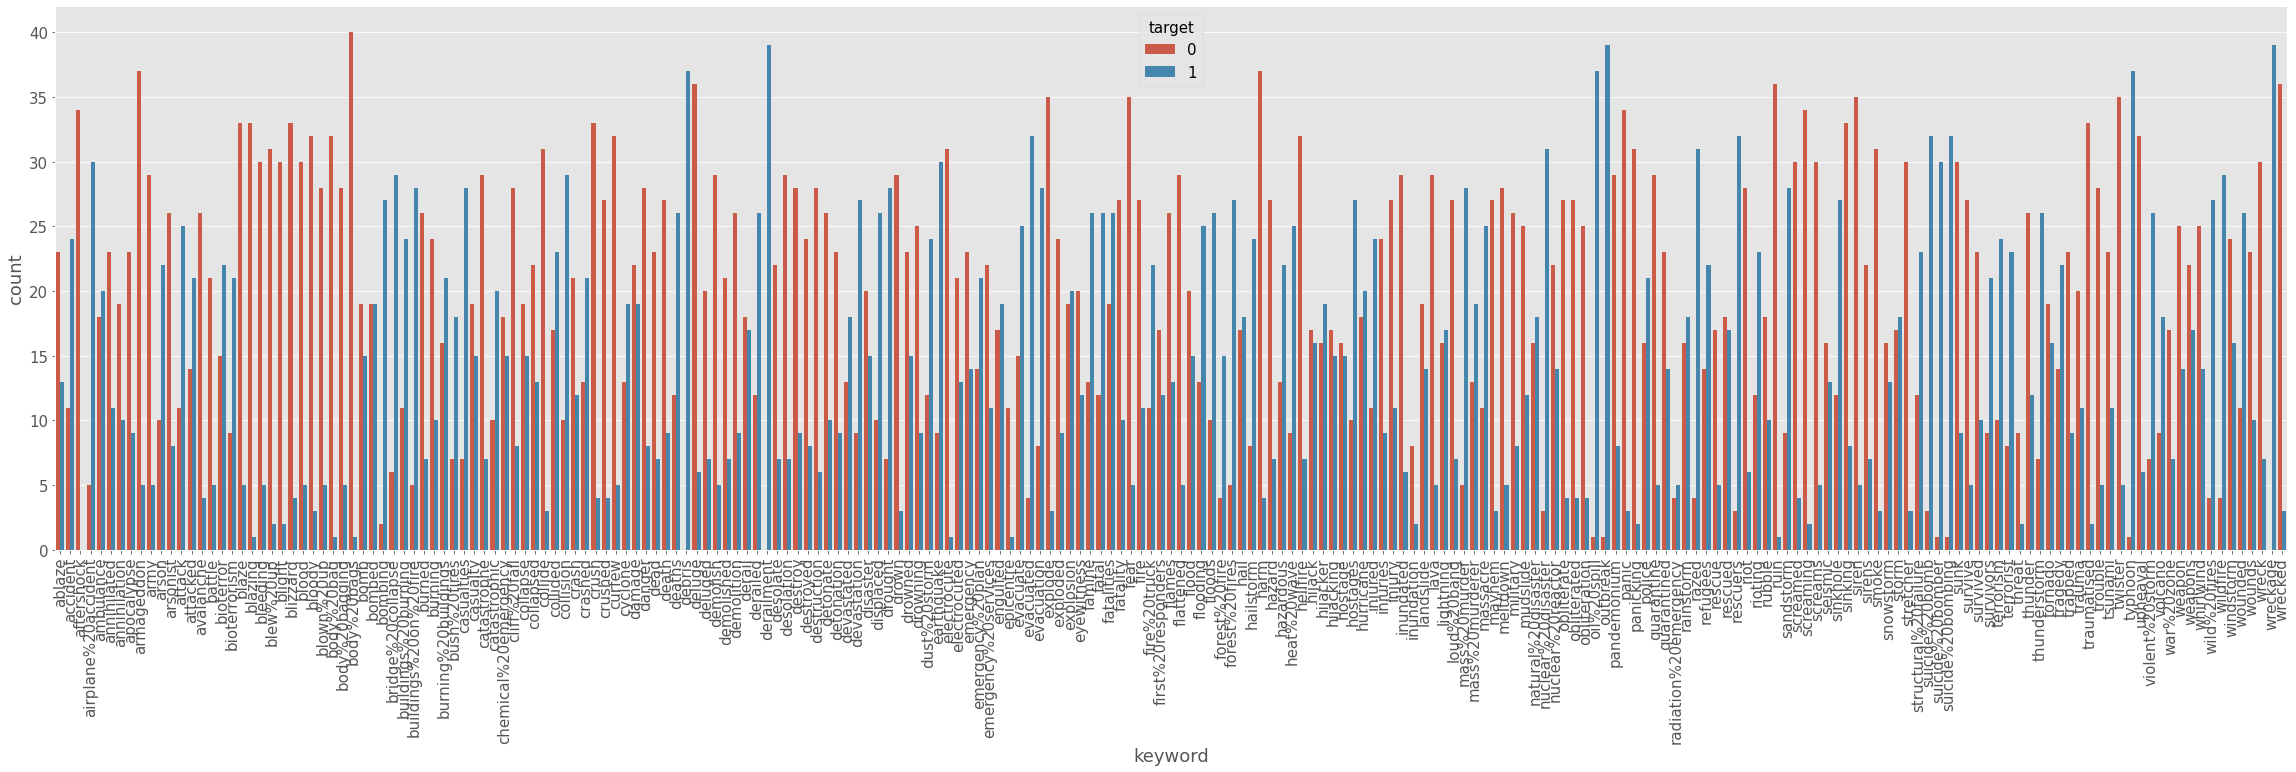

In [141]:
plt.figure(figsize=[40, 10])
sns.countplot(x=KEYWORD, hue=TARGET, data=df_train)
plt.xticks(rotation=90)
plt.show()

Blank spaces indicated by %20

## Target Imabalance

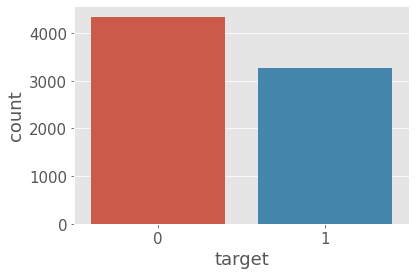

In [142]:
sns.countplot(x=TARGET, data=df_train)
plt.show()

This dataset is imbalanced. The diaprity is of ~1000 datapoints where the number of non-disastrous tweets are higher.

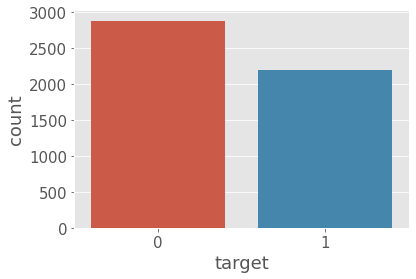

In [143]:
sns.countplot(x=TARGET, data=df_train[~df_train[LOCATION].isna()])
plt.show()

For the tweets whose location is NOT missing, the data imabalance is true in this case as well.

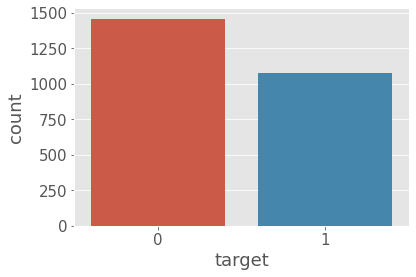

In [144]:
sns.countplot(x=TARGET, data=df_train[df_train[LOCATION].isna()])
plt.show()

For the tweets whose location is missing, the data imabalance is true in this case as well.

## Top 10 locations

In [145]:
df_train[df_train[TARGET] == 1].groupby(LOCATION)[TARGET].count().reset_index()

,location,target
0,,1
1,News,1
2,"616 Û¢ Kentwood , MI",1
3,? ??????? ? ( ?? å¡ ? ? ? å¡),1
4,Alberta,1
...,...,...
1508,"ÌÏT: 40.562796,-75.488849",1
1509,"ÌÏT: 41.252426,-96.072013",1
1510,"ÌÏT: 6.4682,3.18287",1
1511,"ÌÏT: 6.488400524109015,3.352798039832285",1


In [146]:
df_train[df_train[TARGET] == 1].groupby(
    LOCATION)[TARGET].count().reset_index().sort_values(by=TARGET)

,location,target
0,,1
979,Porthcawl,1
978,"Portage, IN / Worldwide",1
977,Port Williams NS,1
976,"Port Orange, FL",1
...,...,...
787,Mumbai,19
576,India,20
857,Nigeria,22
1258,United States,27


In [147]:
df_train[df_train[TARGET] == 1].groupby(
    LOCATION)[TARGET].count().reset_index().sort_values(by=TARGET,
                                                        ascending=False)

,location,target
1248,USA,67
1258,United States,27
857,Nigeria,22
576,India,20
787,Mumbai,19
...,...,...
533,Himalayan Mountains,1
532,Hertfordshire,1
531,"Here, unless there.",1
530,"Here, there and everywhere",1


(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'USA'),
  Text(1, 0, 'United States'),
  Text(2, 0, 'Nigeria'),
  Text(3, 0, 'India'),
  Text(4, 0, 'Mumbai'),
  Text(5, 0, 'UK'),
  Text(6, 0, 'London'),
  Text(7, 0, 'New York'),
  Text(8, 0, 'Washington, DC'),
  Text(9, 0, 'Canada')])

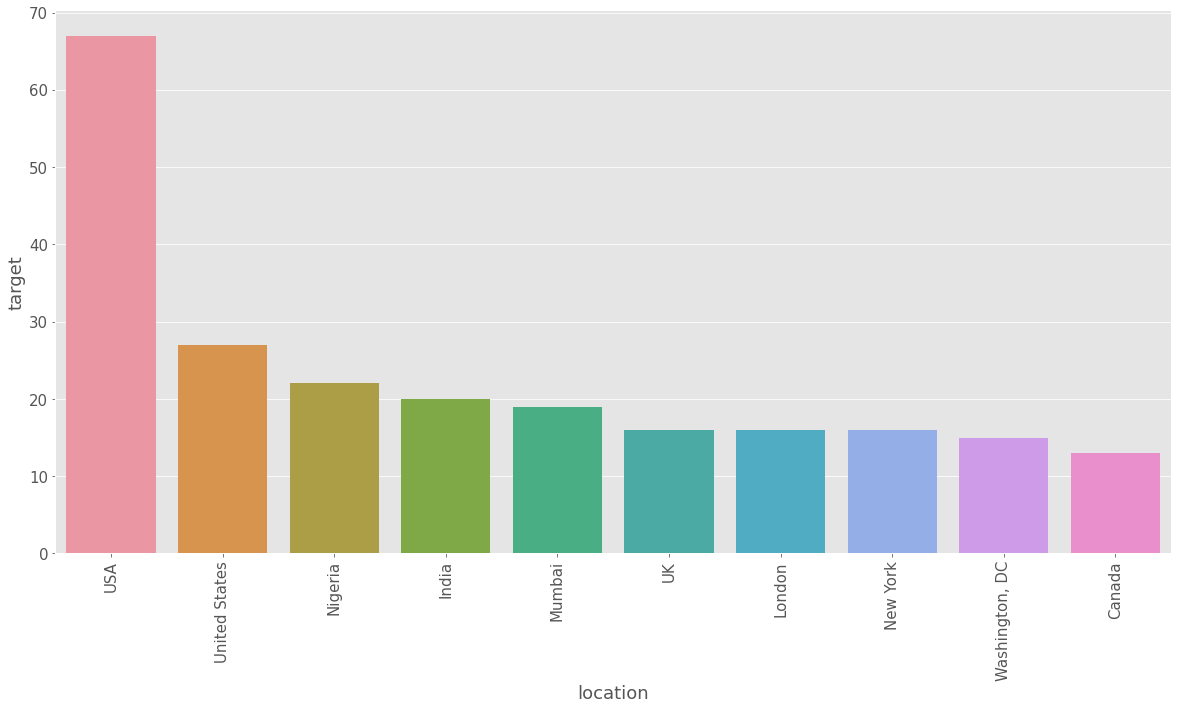

In [148]:
plt.figure(figsize=[20, 10])
sns.barplot(x=LOCATION,
            y=TARGET,
            data=df_train[df_train[TARGET] == 1].groupby(LOCATION)
            [TARGET].count().reset_index().sort_values(by=TARGET,
                                                       ascending=False)[:10])
plt.xticks(rotation=90)

There is an overlap of countries, cities and there are also co-ordinate information plus some gibberish data.

## Text Check

In [149]:
df_train[TEXT][8], df_train[TARGET][8]

("There's an emergency evacuation happening now in the building across the street",
 1)

In [150]:
df_train[TEXT][20], df_train[TARGET][20]

('this is ridiculous....', 0)

In [151]:
df_train[TEXT][1000] , df_train[TARGET][1000]

('#OVOFest Drake straight body bagging Meek on that OVO stage. #ZIPHIMUP!', 0)

In [152]:
df_train[TEXT][2000] , df_train[TARGET][3000]

('@BradleyBrad47 the saw is fast af and does great damage i upgraded it a shitton and used it exclusively for a whole playthrough',
 1)

## Test Data Check

In [153]:
df_test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [154]:
df_test.isnull().sum()

id             0
keyword       26
location    1105
text           0
dtype: int64

**Notes:**

Will remove:
1. urls from the texts, 
2. html tags
3. mentions using @. 

Will retain hashtags since importance information lies in hasgtags but will remove the # in them.

# Basic Cleaning

## Cleaning Tests

In [155]:
test_string = 'I am at https://www.nabanita.org www.nabanita.org okay'
url_pattern = r'(www.|http[s]?://)(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
test_op = re.sub(url_pattern, '', test_string)
test_op

'I am at   okay'

In [156]:
test_string = 'I am at <p>www.nabanita.org &nbsp;</p>'
html_entities = r'<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});'
test_op = re.sub(html_entities, '', test_string)
test_op

'I am at www.nabanita.org '

In [157]:
test_string = 'I am at <p>www.nabanita.org'
html_entities = r'<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});'
test_op = re.sub(html_entities, '', test_string)
test_op

'I am at www.nabanita.org'

In [158]:
test_string = 'I am at @nabanita #python testing 123'
html_entities = r'@([a-z0-9]+)|#'
test_op = re.sub(html_entities, '', test_string)
test_op

'I am at  python testing 123'

## Implementation

In [159]:
def remove_urls(text):
    ''' This method takes in text to remove urls and website links, if any'''
    url_pattern = r'(www.|http[s]?://)(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
    text = re.sub(url_pattern, '', text)
    return text

In [160]:
def remove_html_entities(text):
    ''' This method removes html tags'''
    html_entities = r'<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});'
    text = re.sub(html_entities, '', text)
    return text

In [161]:
def remove_social_media_tags(text):
    ''' This method removes @ and # tags'''
    tag_pattern = r'@([a-z0-9]+)|#'
    text = re.sub(tag_pattern, '', text)
    return text

In [162]:
def convert_lower_case(text):
    return text.lower()

In [163]:
def remove_stopwords(text):
    text = text.split()
    text = " ".join([word for word in text if not word in STOPWORDS])
    return text

In [164]:
df_train[TEXT] = df_train[TEXT].apply(lambda x : remove_urls(x))
df_train[TEXT] = df_train[TEXT].apply(lambda x : remove_html_entities(x))
df_train[TEXT] = df_train[TEXT].apply(lambda x : remove_social_media_tags(x))
df_train[TEXT] = df_train[TEXT].apply(lambda x : convert_lower_case(x))

In [165]:
df_train[TEXT] = df_train[TEXT].apply(lambda x : remove_stopwords(x))

# Mention of Numbers in Tweets

In [166]:
def get_numbers_in_tweet(text):
    list_numbers = re.findall(r'\d+', text)
    if list_numbers:
        return 1
    return 0

In [167]:
df_train['numbers_in_tweet'] = df_train[TEXT].apply(lambda x: get_numbers_in_tweet(x))

In [168]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   id                7613 non-null   int64 
 1   keyword           7552 non-null   object
 2   location          5080 non-null   object
 3   text              7613 non-null   object
 4   target            7613 non-null   int64 
 5   numbers_in_tweet  7613 non-null   int64 
dtypes: int64(3), object(3)
memory usage: 357.0+ KB


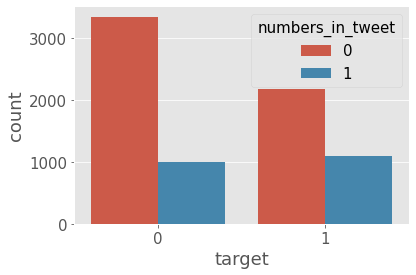

In [169]:
sns.countplot(x=TARGET, hue='numbers_in_tweet', data=df_train)
plt.show()

The probability of having numbers in tweeets about real disasters.

# Sentiment Analysis

In [170]:
import spacy
from spacytextblob.spacytextblob import SpacyTextBlob

In [171]:
nlp = spacy.load('en_core_web_sm')
nlp.add_pipe('spacytextblob')

In [172]:
df_train[SENTIMENT] = df_train[TEXT].apply(lambda x: nlp(x)._.polarity)

In [173]:
df_train.head()

,id,keyword,location,text,target,numbers_in_tweet,sentiment score
0,1,NaN,NaN,deeds reason earthquake may allah forgive us,1,0,0.0
1,4,NaN,NaN,forest fire near la ronge sask. canada,1,0,0.1
2,5,NaN,NaN,residents asked 'shelter place' notified offic...,1,0,-0.1
3,6,NaN,NaN,"13,000 people receive wildfires evacuation ord...",1,1,0.0
4,7,NaN,NaN,got sent photo ruby alaska smoke wildfires pou...,1,0,0.0


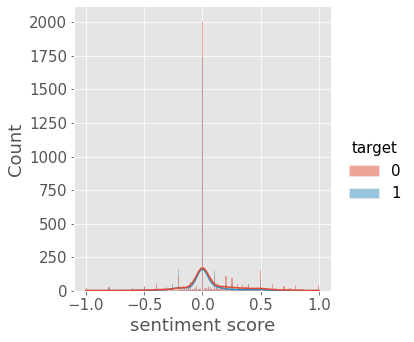

In [174]:
sns.displot(x=SENTIMENT, hue=TARGET, data=df_train, kde=True)
plt.show()

In [175]:
df_train[SENTIMENT_ROUND] = df_train[SENTIMENT].apply(round)
df_train.head()

,id,keyword,location,text,target,numbers_in_tweet,sentiment score,sentiment (rounded off)
0,1,NaN,NaN,deeds reason earthquake may allah forgive us,1,0,0.0,0
1,4,NaN,NaN,forest fire near la ronge sask. canada,1,0,0.1,0
2,5,NaN,NaN,residents asked 'shelter place' notified offic...,1,0,-0.1,0
3,6,NaN,NaN,"13,000 people receive wildfires evacuation ord...",1,1,0.0,0
4,7,NaN,NaN,got sent photo ruby alaska smoke wildfires pou...,1,0,0.0,0


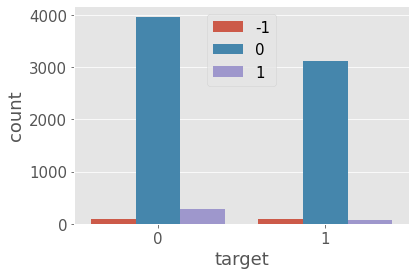

In [176]:
sns.countplot(x=TARGET, hue=SENTIMENT_ROUND, data=df_train)
plt.legend()
plt.show()

# Location Analysis

In [177]:
# import time
# from geopy.geocoders import Nominatim

# geolocator = Nominatim(user_agent="my_app")

# def print_location(loc):
#     if loc:
#         try:
#             location = geolocator.geocode(loc)
#             return location
#         except:
#             time.sleep(1)
#             try:
#                 location = geolocator.geocode(loc)
#                 return location
#             except:
#                 print(loc)

# df_train[_LOCATION_] = df_train[LOCATION].apply(lambda x: print_location(x))
# df_train.head()

In [178]:
def check_location(spacy_loc):
    ''' This method checks if the tweet location has any actual location 
    and saves them as as space-separated value if more than one.
    If no location is found, then save blank'''
    num_loc_in_tweet = len([ent.label_ for ent in spacy_loc.ents if ent.label_ == 'GPE'])
    if num_loc_in_tweet:
        locs_in_tweet = [ent.text for ent in spacy_loc.ents if ent.label_ == 'GPE']
    else:
        return nlp('')
    return nlp(' '.join(locs_in_tweet))

df_train[LOCATION].fillna('', inplace=True)
df_train[_LOC_SPACY_OBJ_] = df_train[LOCATION].apply(nlp)
df_train[_LOC_SPACY_OBJ_] = df_train[_LOC_SPACY_OBJ_].apply(check_location)

# Tweet Length Analysis

In [179]:
df_train[_TEXT_SPACY_OBJ_] = df_train[TEXT].apply(nlp)

In [180]:
df_train.head()

,id,keyword,location,text,target,numbers_in_tweet,sentiment score,sentiment (rounded off),_LOC_SPACY_OBJ_,_TEXT_SPACY_OBJ_
0,1,NaN,,deeds reason earthquake may allah forgive us,1,0,0.0,0,(),"(deeds, reason, earthquake, may, allah, forgiv..."
1,4,NaN,,forest fire near la ronge sask. canada,1,0,0.1,0,(),"(forest, fire, near, la, ronge, sask, ., canada)"
2,5,NaN,,residents asked 'shelter place' notified offic...,1,0,-0.1,0,(),"(residents, asked, ', shelter, place, ', notif..."
3,6,NaN,,"13,000 people receive wildfires evacuation ord...",1,1,0.0,0,(),"(13,000, people, receive, wildfires, evacuatio..."
4,7,NaN,,got sent photo ruby alaska smoke wildfires pou...,1,0,0.0,0,(),"(got, sent, photo, ruby, alaska, smoke, wildfi..."


In [181]:
df_train[_WORDS_PER_TWEET_] = df_train[_TEXT_SPACY_OBJ_].apply(len)
df_train[_CHAR_PER_TWEET_] = df_train[TEXT].apply(len)

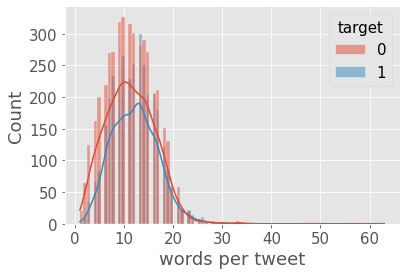

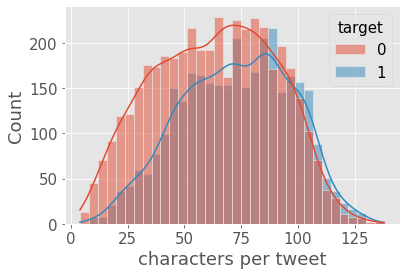

In [182]:
sns.histplot(x=_WORDS_PER_TWEET_, hue=TARGET, data=df_train, kde=True)
plt.show()
sns.histplot(x=_CHAR_PER_TWEET_, hue=TARGET, data=df_train, kde=True)
plt.show()

# Data Modelling

In [183]:
from spacy.tokens import Doc
df_train[ALL_TEXT] = df_train.apply(lambda x: Doc.from_docs([x[_TEXT_SPACY_OBJ_], x[_LOC_SPACY_OBJ_]]), axis=1)
df_train[ALL_TEXT] = df_train[ALL_TEXT].apply(lambda x: [token.text for token in x])

In [184]:
df_train.head(2)

,id,keyword,location,text,target,numbers_in_tweet,sentiment score,sentiment (rounded off),_LOC_SPACY_OBJ_,_TEXT_SPACY_OBJ_,words per tweet,characters per tweet,all_text
0,1,NaN,,deeds reason earthquake may allah forgive us,1,0,0.0,0,(),"(deeds, reason, earthquake, may, allah, forgiv...",7,44,"[deeds, reason, earthquake, may, allah, forgiv..."
1,4,NaN,,forest fire near la ronge sask. canada,1,0,0.1,0,(),"(forest, fire, near, la, ronge, sask, ., canada)",8,38,"[forest, fire, near, la, ronge, sask, ., canada]"


In [185]:
df_train[df_train[ID] == 48][ALL_TEXT]

31    [wholesale, markets, ablaze, Birmingham]
Name: all_text, dtype: object

In [186]:
target = df_train[TARGET].values
df_train[ALL_TEXT_JOINED] = df_train[ALL_TEXT].apply(lambda x: " ".join(x))

In [187]:
count_vectorizer = CountVectorizer(ngram_range=(1, 2))
tf_idf_transformer = TfidfTransformer(smooth_idf=False)

In [188]:
count_vectorizer.fit(df_train[ALL_TEXT_JOINED].values)
count_vect_train = count_vectorizer.transform(df_train[ALL_TEXT_JOINED].values)

In [189]:
tf_idf_transformer.fit(count_vect_train)
tf_idf_train = tf_idf_transformer.transform(count_vect_train)

In [190]:
X_train, X_test, y_train, y_test = train_test_split(tf_idf_train, target, random_state=0)

## Baseline Selection

In [137]:
df_perf_metrics = pd.DataFrame(columns=[
    'Model', 'Accuracy_Training_Set', 'Accuracy_Test_Set', 'Precision',
    'Recall', 'f1_score'
])

In [138]:
df_perf_metrics = pd.DataFrame(columns=[
    'Model', 'Accuracy_Training_Set', 'Accuracy_Test_Set', 'Precision',
    'Recall', 'f1_score', 'Training Time (secs'
])
models_trained_list = []


def get_perf_metrics(model, i):
    # model name
    model_name = type(model).__name__
    # time keeping
    start_time = time.time()
    print("Training {} model...".format(model_name))
    # Fitting of model
    model.fit(X_train, y_train)
    print("Completed {} model training.".format(model_name))
    elapsed_time = time.time() - start_time
    # Time Elapsed
    print("Time elapsed: {:.2f} s.".format(elapsed_time))
    # Predictions
    y_pred = model.predict(X_test)
    # Add to ith row of dataframe - metrics
    df_perf_metrics.loc[i] = [
        model_name,
        model.score(X_train, y_train),
        model.score(X_test, y_test),
        precision_score(y_test, y_pred),
        recall_score(y_test, y_pred),
        f1_score(y_test, y_pred), "{:.2f}".format(elapsed_time)
    ]
    # keep a track of trained models
    models_trained_list.append(model)
    print("Completed {} model's performance assessment.".format(model_name))

In [139]:
models_list = [LogisticRegression(),
               MultinomialNB(),
               RandomForestClassifier(),
               DecisionTreeClassifier(),
               GradientBoostingClassifier(),
               AdaBoostClassifier()]

In [142]:
for n, model in enumerate(models_list):
    get_perf_metrics(model, n)

Training LogisticRegression model...
Completed LogisticRegression model training.
Time elapsed: 1.23 s.
Completed LogisticRegression model's performance assessment.
Training MultinomialNB model...
Completed MultinomialNB model training.
Time elapsed: 0.02 s.
Completed MultinomialNB model's performance assessment.
Training RandomForestClassifier model...
Completed RandomForestClassifier model training.
Time elapsed: 147.31 s.
Completed RandomForestClassifier model's performance assessment.
Training DecisionTreeClassifier model...
Completed DecisionTreeClassifier model training.
Time elapsed: 9.60 s.
Completed DecisionTreeClassifier model's performance assessment.
Training GradientBoostingClassifier model...
Completed GradientBoostingClassifier model training.
Time elapsed: 200.81 s.
Completed GradientBoostingClassifier model's performance assessment.
Training AdaBoostClassifier model...
Completed AdaBoostClassifier model training.
Time elapsed: 97.57 s.
Completed AdaBoostClassifier mode

In [143]:
df_perf_metrics

,Model,Accuracy_Training_Set,Accuracy_Test_Set,Precision,Recall,f1_score,Training Time (secs
0,LogisticRegression,0.913120,0.797269,0.888469,0.589711,0.708899,1.23
1,MultinomialNB,0.935365,0.797269,0.887006,0.590966,0.709337,0.02
2,RandomForestClassifier,0.991242,0.774685,0.888186,0.528231,0.662470,147.31
3,DecisionTreeClassifier,0.991242,0.720063,0.675066,0.638645,0.656351,9.60
4,GradientBoostingClassifier,0.785777,0.743172,0.799611,0.515684,0.627002,200.81
5,AdaBoostClassifier,0.763706,0.754202,0.786087,0.567127,0.658892,97.57


## Reviewing default config predictions after stopwords removal

In [191]:
# Same code as the above section but with stopwords removed text data
# This is to preserve the results and draw before and after comparison
# if no improvement, will not run the following codes

df_perf_metrics = pd.DataFrame(columns=[
    'Model', 'Accuracy_Training_Set', 'Accuracy_Test_Set', 'Precision',
    'Recall', 'f1_score'
])

df_perf_metrics = pd.DataFrame(columns=[
    'Model', 'Accuracy_Training_Set', 'Accuracy_Test_Set', 'Precision',
    'Recall', 'f1_score', 'Training Time (secs'
])
models_trained_list = []


def get_perf_metrics(model, i):
    # model name
    model_name = type(model).__name__
    # time keeping
    start_time = time.time()
    print("Training {} model...".format(model_name))
    # Fitting of model
    model.fit(X_train, y_train)
    print("Completed {} model training.".format(model_name))
    elapsed_time = time.time() - start_time
    # Time Elapsed
    print("Time elapsed: {:.2f} s.".format(elapsed_time))
    # Predictions
    y_pred = model.predict(X_test)
    # Add to ith row of dataframe - metrics
    df_perf_metrics.loc[i] = [
        model_name,
        model.score(X_train, y_train),
        model.score(X_test, y_test),
        precision_score(y_test, y_pred),
        recall_score(y_test, y_pred),
        f1_score(y_test, y_pred), "{:.2f}".format(elapsed_time)
    ]
    # keep a track of trained models
    models_trained_list.append(model)
    print("Completed {} model's performance assessment.".format(model_name))

models_list = [LogisticRegression(),
               MultinomialNB(),
               RandomForestClassifier(),
               DecisionTreeClassifier(),
               GradientBoostingClassifier(),
               AdaBoostClassifier()]

for n, model in enumerate(models_list):
    get_perf_metrics(model, n)

df_perf_metrics

Training LogisticRegression model...
Completed LogisticRegression model training.
Time elapsed: 0.52 s.
Completed LogisticRegression model's performance assessment.
Training MultinomialNB model...
Completed MultinomialNB model training.
Time elapsed: 0.01 s.
Completed MultinomialNB model's performance assessment.
Training RandomForestClassifier model...
Completed RandomForestClassifier model training.
Time elapsed: 67.86 s.
Completed RandomForestClassifier model's performance assessment.
Training DecisionTreeClassifier model...
Completed DecisionTreeClassifier model training.
Time elapsed: 4.19 s.
Completed DecisionTreeClassifier model's performance assessment.
Training GradientBoostingClassifier model...
Completed GradientBoostingClassifier model training.
Time elapsed: 66.70 s.
Completed GradientBoostingClassifier model's performance assessment.
Training AdaBoostClassifier model...
Completed AdaBoostClassifier model training.
Time elapsed: 31.73 s.
Completed AdaBoostClassifier model'

,Model,Accuracy_Training_Set,Accuracy_Test_Set,Precision,Recall,f1_score,Training Time (secs
0,LogisticRegression,0.916623,0.786765,0.906445,0.547051,0.682316,0.52
1,MultinomialNB,0.954983,0.795168,0.861456,0.608532,0.713235,0.01
2,RandomForestClassifier,0.991242,0.783613,0.869482,0.568381,0.687405,67.86
3,DecisionTreeClassifier,0.991242,0.744223,0.695214,0.692597,0.693903,4.19
4,GradientBoostingClassifier,0.770187,0.744223,0.865566,0.460477,0.601147,66.70
5,AdaBoostClassifier,0.769136,0.758403,0.799290,0.564617,0.661765,31.73


# HyperParameter Tuning for Model Improvement

Random Forest Classifier

## Attempt 1

In [146]:
max_depth = [5, 8, 15, 25, 30]
min_samples_leaf = [1, 2, 5, 10]
min_samples_split = [2, 5, 10, 15, 100]
n_estimators = [100, 300, 500, 800, 1200]

param_grid = dict(n_estimators=n_estimators,
                  max_depth = max_depth,
                  min_samples_split = min_samples_split,
                  min_samples_leaf = min_samples_leaf
                 )

model = RandomForestClassifier()

grid = GridSearchCV(estimator=model,
                    param_grid=param_grid,
                    cv=5,
                    scoring=['f1'],
                    refit='f1',
                    verbose=2)

grid_result = grid.fit(X_train, y_train)

Fitting 5 folds for each of 500 candidates, totalling 2500 fits
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   2.3s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   2.4s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   2.4s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   2.5s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   2.4s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   7.3s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   7.5s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   7.8s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   7.4s
[CV] END max_depth=5, min_samples_le

[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=15, n_estimators=300; total time=   6.8s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=15, n_estimators=300; total time=   6.9s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=15, n_estimators=300; total time=   7.2s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=15, n_estimators=300; total time=   7.1s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=15, n_estimators=500; total time=  11.8s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=15, n_estimators=500; total time=  11.9s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=15, n_estimators=500; total time=  13.0s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=15, n_estimators=500; total time=  11.9s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=15, n_estimators=500; total time=  11.9s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=15, n_estimators=800; total tim

[CV] END max_depth=5, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  11.5s
[CV] END max_depth=5, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  11.6s
[CV] END max_depth=5, min_samples_leaf=2, min_samples_split=5, n_estimators=800; total time=  18.3s
[CV] END max_depth=5, min_samples_leaf=2, min_samples_split=5, n_estimators=800; total time=  18.2s
[CV] END max_depth=5, min_samples_leaf=2, min_samples_split=5, n_estimators=800; total time=  18.2s
[CV] END max_depth=5, min_samples_leaf=2, min_samples_split=5, n_estimators=800; total time=  18.3s
[CV] END max_depth=5, min_samples_leaf=2, min_samples_split=5, n_estimators=800; total time=  18.5s
[CV] END max_depth=5, min_samples_leaf=2, min_samples_split=5, n_estimators=1200; total time=  27.6s
[CV] END max_depth=5, min_samples_leaf=2, min_samples_split=5, n_estimators=1200; total time=  27.9s
[CV] END max_depth=5, min_samples_leaf=2, min_samples_split=5, n_estimators=1200; total time=  28.

[CV] END max_depth=5, min_samples_leaf=2, min_samples_split=100, n_estimators=800; total time=  18.5s
[CV] END max_depth=5, min_samples_leaf=2, min_samples_split=100, n_estimators=1200; total time=  27.8s
[CV] END max_depth=5, min_samples_leaf=2, min_samples_split=100, n_estimators=1200; total time=  28.4s
[CV] END max_depth=5, min_samples_leaf=2, min_samples_split=100, n_estimators=1200; total time=  27.3s
[CV] END max_depth=5, min_samples_leaf=2, min_samples_split=100, n_estimators=1200; total time=  27.2s
[CV] END max_depth=5, min_samples_leaf=2, min_samples_split=100, n_estimators=1200; total time=  27.5s
[CV] END max_depth=5, min_samples_leaf=5, min_samples_split=2, n_estimators=100; total time=   2.2s
[CV] END max_depth=5, min_samples_leaf=5, min_samples_split=2, n_estimators=100; total time=   2.2s
[CV] END max_depth=5, min_samples_leaf=5, min_samples_split=2, n_estimators=100; total time=   2.3s
[CV] END max_depth=5, min_samples_leaf=5, min_samples_split=2, n_estimators=100; to

[CV] END max_depth=5, min_samples_leaf=5, min_samples_split=15, n_estimators=100; total time=   2.3s
[CV] END max_depth=5, min_samples_leaf=5, min_samples_split=15, n_estimators=100; total time=   2.3s
[CV] END max_depth=5, min_samples_leaf=5, min_samples_split=15, n_estimators=100; total time=   2.3s
[CV] END max_depth=5, min_samples_leaf=5, min_samples_split=15, n_estimators=100; total time=   2.3s
[CV] END max_depth=5, min_samples_leaf=5, min_samples_split=15, n_estimators=300; total time=   7.0s
[CV] END max_depth=5, min_samples_leaf=5, min_samples_split=15, n_estimators=300; total time=   7.0s
[CV] END max_depth=5, min_samples_leaf=5, min_samples_split=15, n_estimators=300; total time=   7.1s
[CV] END max_depth=5, min_samples_leaf=5, min_samples_split=15, n_estimators=300; total time=   7.1s
[CV] END max_depth=5, min_samples_leaf=5, min_samples_split=15, n_estimators=300; total time=   7.2s
[CV] END max_depth=5, min_samples_leaf=5, min_samples_split=15, n_estimators=500; total tim

[CV] END max_depth=5, min_samples_leaf=10, min_samples_split=5, n_estimators=300; total time=   1.7s
[CV] END max_depth=5, min_samples_leaf=10, min_samples_split=5, n_estimators=300; total time=   1.7s
[CV] END max_depth=5, min_samples_leaf=10, min_samples_split=5, n_estimators=300; total time=   1.8s
[CV] END max_depth=5, min_samples_leaf=10, min_samples_split=5, n_estimators=500; total time=   2.9s
[CV] END max_depth=5, min_samples_leaf=10, min_samples_split=5, n_estimators=500; total time=   2.9s
[CV] END max_depth=5, min_samples_leaf=10, min_samples_split=5, n_estimators=500; total time=   2.8s
[CV] END max_depth=5, min_samples_leaf=10, min_samples_split=5, n_estimators=500; total time=   2.9s
[CV] END max_depth=5, min_samples_leaf=10, min_samples_split=5, n_estimators=500; total time=   2.9s
[CV] END max_depth=5, min_samples_leaf=10, min_samples_split=5, n_estimators=800; total time=   4.7s
[CV] END max_depth=5, min_samples_leaf=10, min_samples_split=5, n_estimators=800; total tim

[CV] END max_depth=5, min_samples_leaf=10, min_samples_split=100, n_estimators=500; total time=   4.3s
[CV] END max_depth=5, min_samples_leaf=10, min_samples_split=100, n_estimators=500; total time=   4.3s
[CV] END max_depth=5, min_samples_leaf=10, min_samples_split=100, n_estimators=800; total time=   6.9s
[CV] END max_depth=5, min_samples_leaf=10, min_samples_split=100, n_estimators=800; total time=   7.0s
[CV] END max_depth=5, min_samples_leaf=10, min_samples_split=100, n_estimators=800; total time=   7.1s
[CV] END max_depth=5, min_samples_leaf=10, min_samples_split=100, n_estimators=800; total time=   7.2s
[CV] END max_depth=5, min_samples_leaf=10, min_samples_split=100, n_estimators=800; total time=   7.1s
[CV] END max_depth=5, min_samples_leaf=10, min_samples_split=100, n_estimators=1200; total time=  10.9s
[CV] END max_depth=5, min_samples_leaf=10, min_samples_split=100, n_estimators=1200; total time=  11.1s
[CV] END max_depth=5, min_samples_leaf=10, min_samples_split=100, n_est

[CV] END max_depth=8, min_samples_leaf=1, min_samples_split=10, n_estimators=1200; total time=  13.0s
[CV] END max_depth=8, min_samples_leaf=1, min_samples_split=10, n_estimators=1200; total time=  13.0s
[CV] END max_depth=8, min_samples_leaf=1, min_samples_split=10, n_estimators=1200; total time=463.5min
[CV] END max_depth=8, min_samples_leaf=1, min_samples_split=10, n_estimators=1200; total time=  16.6s
[CV] END max_depth=8, min_samples_leaf=1, min_samples_split=10, n_estimators=1200; total time=  15.6s
[CV] END max_depth=8, min_samples_leaf=1, min_samples_split=15, n_estimators=100; total time=   1.1s
[CV] END max_depth=8, min_samples_leaf=1, min_samples_split=15, n_estimators=100; total time=   1.0s
[CV] END max_depth=8, min_samples_leaf=1, min_samples_split=15, n_estimators=100; total time=   0.9s
[CV] END max_depth=8, min_samples_leaf=1, min_samples_split=15, n_estimators=100; total time=   0.9s
[CV] END max_depth=8, min_samples_leaf=1, min_samples_split=15, n_estimators=100; tot

[CV] END max_depth=8, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.8s
[CV] END max_depth=8, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.8s
[CV] END max_depth=8, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.8s
[CV] END max_depth=8, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.9s
[CV] END max_depth=8, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=   2.7s
[CV] END max_depth=8, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=   2.7s
[CV] END max_depth=8, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=   2.7s
[CV] END max_depth=8, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=   2.7s
[CV] END max_depth=8, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=   2.7s
[CV] END max_depth=8, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=   4.6s


[CV] END max_depth=8, min_samples_leaf=2, min_samples_split=100, n_estimators=300; total time=   2.7s
[CV] END max_depth=8, min_samples_leaf=2, min_samples_split=100, n_estimators=300; total time=   2.8s
[CV] END max_depth=8, min_samples_leaf=2, min_samples_split=100, n_estimators=500; total time=   4.5s
[CV] END max_depth=8, min_samples_leaf=2, min_samples_split=100, n_estimators=500; total time=   4.5s
[CV] END max_depth=8, min_samples_leaf=2, min_samples_split=100, n_estimators=500; total time=   4.6s
[CV] END max_depth=8, min_samples_leaf=2, min_samples_split=100, n_estimators=500; total time=   4.7s
[CV] END max_depth=8, min_samples_leaf=2, min_samples_split=100, n_estimators=500; total time=   4.6s
[CV] END max_depth=8, min_samples_leaf=2, min_samples_split=100, n_estimators=800; total time=   7.3s
[CV] END max_depth=8, min_samples_leaf=2, min_samples_split=100, n_estimators=800; total time=   7.2s
[CV] END max_depth=8, min_samples_leaf=2, min_samples_split=100, n_estimators=800;

[CV] END max_depth=8, min_samples_leaf=5, min_samples_split=10, n_estimators=800; total time=   7.3s
[CV] END max_depth=8, min_samples_leaf=5, min_samples_split=10, n_estimators=800; total time=   7.3s
[CV] END max_depth=8, min_samples_leaf=5, min_samples_split=10, n_estimators=800; total time=   7.3s
[CV] END max_depth=8, min_samples_leaf=5, min_samples_split=10, n_estimators=800; total time=   7.3s
[CV] END max_depth=8, min_samples_leaf=5, min_samples_split=10, n_estimators=800; total time=   7.4s
[CV] END max_depth=8, min_samples_leaf=5, min_samples_split=10, n_estimators=1200; total time=  11.0s
[CV] END max_depth=8, min_samples_leaf=5, min_samples_split=10, n_estimators=1200; total time=  10.9s
[CV] END max_depth=8, min_samples_leaf=5, min_samples_split=10, n_estimators=1200; total time=  11.0s
[CV] END max_depth=8, min_samples_leaf=5, min_samples_split=10, n_estimators=1200; total time=  11.3s
[CV] END max_depth=8, min_samples_leaf=5, min_samples_split=10, n_estimators=1200; tota

[CV] END max_depth=8, min_samples_leaf=10, min_samples_split=2, n_estimators=1200; total time=   9.6s
[CV] END max_depth=8, min_samples_leaf=10, min_samples_split=2, n_estimators=1200; total time=   9.5s
[CV] END max_depth=8, min_samples_leaf=10, min_samples_split=2, n_estimators=1200; total time=   9.7s
[CV] END max_depth=8, min_samples_leaf=10, min_samples_split=2, n_estimators=1200; total time=   9.6s
[CV] END max_depth=8, min_samples_leaf=10, min_samples_split=5, n_estimators=100; total time=   0.7s
[CV] END max_depth=8, min_samples_leaf=10, min_samples_split=5, n_estimators=100; total time=   0.7s
[CV] END max_depth=8, min_samples_leaf=10, min_samples_split=5, n_estimators=100; total time=   0.7s
[CV] END max_depth=8, min_samples_leaf=10, min_samples_split=5, n_estimators=100; total time=   0.7s
[CV] END max_depth=8, min_samples_leaf=10, min_samples_split=5, n_estimators=100; total time=   0.7s
[CV] END max_depth=8, min_samples_leaf=10, min_samples_split=5, n_estimators=300; total

[CV] END max_depth=8, min_samples_leaf=10, min_samples_split=100, n_estimators=100; total time=   0.7s
[CV] END max_depth=8, min_samples_leaf=10, min_samples_split=100, n_estimators=100; total time=   0.7s
[CV] END max_depth=8, min_samples_leaf=10, min_samples_split=100, n_estimators=100; total time=   0.7s
[CV] END max_depth=8, min_samples_leaf=10, min_samples_split=100, n_estimators=300; total time=   2.3s
[CV] END max_depth=8, min_samples_leaf=10, min_samples_split=100, n_estimators=300; total time=   2.3s
[CV] END max_depth=8, min_samples_leaf=10, min_samples_split=100, n_estimators=300; total time=   2.3s
[CV] END max_depth=8, min_samples_leaf=10, min_samples_split=100, n_estimators=300; total time=   2.3s
[CV] END max_depth=8, min_samples_leaf=10, min_samples_split=100, n_estimators=300; total time=   2.3s
[CV] END max_depth=8, min_samples_leaf=10, min_samples_split=100, n_estimators=500; total time=   3.8s
[CV] END max_depth=8, min_samples_leaf=10, min_samples_split=100, n_estim

[CV] END max_depth=15, min_samples_leaf=1, min_samples_split=10, n_estimators=300; total time=   5.1s
[CV] END max_depth=15, min_samples_leaf=1, min_samples_split=10, n_estimators=300; total time=   5.1s
[CV] END max_depth=15, min_samples_leaf=1, min_samples_split=10, n_estimators=500; total time=   8.6s
[CV] END max_depth=15, min_samples_leaf=1, min_samples_split=10, n_estimators=500; total time=   8.4s
[CV] END max_depth=15, min_samples_leaf=1, min_samples_split=10, n_estimators=500; total time=   8.4s
[CV] END max_depth=15, min_samples_leaf=1, min_samples_split=10, n_estimators=500; total time=   8.5s
[CV] END max_depth=15, min_samples_leaf=1, min_samples_split=10, n_estimators=500; total time=   8.7s
[CV] END max_depth=15, min_samples_leaf=1, min_samples_split=10, n_estimators=800; total time=  13.6s
[CV] END max_depth=15, min_samples_leaf=1, min_samples_split=10, n_estimators=800; total time=  13.4s
[CV] END max_depth=15, min_samples_leaf=1, min_samples_split=10, n_estimators=800;

[CV] END max_depth=15, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=   8.3s
[CV] END max_depth=15, min_samples_leaf=2, min_samples_split=2, n_estimators=800; total time=  13.0s
[CV] END max_depth=15, min_samples_leaf=2, min_samples_split=2, n_estimators=800; total time=  13.0s
[CV] END max_depth=15, min_samples_leaf=2, min_samples_split=2, n_estimators=800; total time=  12.9s
[CV] END max_depth=15, min_samples_leaf=2, min_samples_split=2, n_estimators=800; total time=  13.0s
[CV] END max_depth=15, min_samples_leaf=2, min_samples_split=2, n_estimators=800; total time=  14.5s
[CV] END max_depth=15, min_samples_leaf=2, min_samples_split=2, n_estimators=1200; total time=  20.2s
[CV] END max_depth=15, min_samples_leaf=2, min_samples_split=2, n_estimators=1200; total time=  19.5s
[CV] END max_depth=15, min_samples_leaf=2, min_samples_split=2, n_estimators=1200; total time=  19.5s
[CV] END max_depth=15, min_samples_leaf=2, min_samples_split=2, n_estimators=1200; total

[CV] END max_depth=15, min_samples_leaf=2, min_samples_split=15, n_estimators=1200; total time=  19.2s
[CV] END max_depth=15, min_samples_leaf=2, min_samples_split=15, n_estimators=1200; total time=  19.2s
[CV] END max_depth=15, min_samples_leaf=2, min_samples_split=15, n_estimators=1200; total time=  19.2s
[CV] END max_depth=15, min_samples_leaf=2, min_samples_split=15, n_estimators=1200; total time=  19.6s
[CV] END max_depth=15, min_samples_leaf=2, min_samples_split=15, n_estimators=1200; total time=  19.4s
[CV] END max_depth=15, min_samples_leaf=2, min_samples_split=100, n_estimators=100; total time=   1.5s
[CV] END max_depth=15, min_samples_leaf=2, min_samples_split=100, n_estimators=100; total time=   1.5s
[CV] END max_depth=15, min_samples_leaf=2, min_samples_split=100, n_estimators=100; total time=   1.5s
[CV] END max_depth=15, min_samples_leaf=2, min_samples_split=100, n_estimators=100; total time=   1.5s
[CV] END max_depth=15, min_samples_leaf=2, min_samples_split=100, n_estim

[CV] END max_depth=15, min_samples_leaf=5, min_samples_split=10, n_estimators=100; total time=   1.6s
[CV] END max_depth=15, min_samples_leaf=5, min_samples_split=10, n_estimators=100; total time=   1.6s
[CV] END max_depth=15, min_samples_leaf=5, min_samples_split=10, n_estimators=100; total time=   1.6s
[CV] END max_depth=15, min_samples_leaf=5, min_samples_split=10, n_estimators=100; total time=   1.6s
[CV] END max_depth=15, min_samples_leaf=5, min_samples_split=10, n_estimators=300; total time=   5.1s
[CV] END max_depth=15, min_samples_leaf=5, min_samples_split=10, n_estimators=300; total time=   5.0s
[CV] END max_depth=15, min_samples_leaf=5, min_samples_split=10, n_estimators=300; total time=   5.0s
[CV] END max_depth=15, min_samples_leaf=5, min_samples_split=10, n_estimators=300; total time=   4.9s
[CV] END max_depth=15, min_samples_leaf=5, min_samples_split=10, n_estimators=300; total time=   5.0s
[CV] END max_depth=15, min_samples_leaf=5, min_samples_split=10, n_estimators=500;

[CV] END max_depth=15, min_samples_leaf=10, min_samples_split=2, n_estimators=300; total time=   3.7s
[CV] END max_depth=15, min_samples_leaf=10, min_samples_split=2, n_estimators=300; total time=   3.6s
[CV] END max_depth=15, min_samples_leaf=10, min_samples_split=2, n_estimators=300; total time=   3.6s
[CV] END max_depth=15, min_samples_leaf=10, min_samples_split=2, n_estimators=300; total time=   3.5s
[CV] END max_depth=15, min_samples_leaf=10, min_samples_split=2, n_estimators=500; total time=   5.9s
[CV] END max_depth=15, min_samples_leaf=10, min_samples_split=2, n_estimators=500; total time=   5.9s
[CV] END max_depth=15, min_samples_leaf=10, min_samples_split=2, n_estimators=500; total time=   5.8s
[CV] END max_depth=15, min_samples_leaf=10, min_samples_split=2, n_estimators=500; total time=   5.9s
[CV] END max_depth=15, min_samples_leaf=10, min_samples_split=2, n_estimators=500; total time=   6.2s
[CV] END max_depth=15, min_samples_leaf=10, min_samples_split=2, n_estimators=800;

[CV] END max_depth=15, min_samples_leaf=10, min_samples_split=15, n_estimators=500; total time=   5.9s
[CV] END max_depth=15, min_samples_leaf=10, min_samples_split=15, n_estimators=500; total time=   6.3s
[CV] END max_depth=15, min_samples_leaf=10, min_samples_split=15, n_estimators=500; total time=   6.1s
[CV] END max_depth=15, min_samples_leaf=10, min_samples_split=15, n_estimators=500; total time=   6.1s
[CV] END max_depth=15, min_samples_leaf=10, min_samples_split=15, n_estimators=800; total time=   9.6s
[CV] END max_depth=15, min_samples_leaf=10, min_samples_split=15, n_estimators=800; total time=  10.0s
[CV] END max_depth=15, min_samples_leaf=10, min_samples_split=15, n_estimators=800; total time=   9.9s
[CV] END max_depth=15, min_samples_leaf=10, min_samples_split=15, n_estimators=800; total time=   9.7s
[CV] END max_depth=15, min_samples_leaf=10, min_samples_split=15, n_estimators=800; total time=   9.6s
[CV] END max_depth=15, min_samples_leaf=10, min_samples_split=15, n_estim

[CV] END max_depth=25, min_samples_leaf=1, min_samples_split=5, n_estimators=800; total time=  23.7s
[CV] END max_depth=25, min_samples_leaf=1, min_samples_split=5, n_estimators=800; total time=  23.9s
[CV] END max_depth=25, min_samples_leaf=1, min_samples_split=5, n_estimators=800; total time=  24.1s
[CV] END max_depth=25, min_samples_leaf=1, min_samples_split=5, n_estimators=800; total time=  24.1s
[CV] END max_depth=25, min_samples_leaf=1, min_samples_split=5, n_estimators=1200; total time=  35.5s
[CV] END max_depth=25, min_samples_leaf=1, min_samples_split=5, n_estimators=1200; total time=  35.4s
[CV] END max_depth=25, min_samples_leaf=1, min_samples_split=5, n_estimators=1200; total time=  36.4s
[CV] END max_depth=25, min_samples_leaf=1, min_samples_split=5, n_estimators=1200; total time=  35.7s
[CV] END max_depth=25, min_samples_leaf=1, min_samples_split=5, n_estimators=1200; total time=  36.8s
[CV] END max_depth=25, min_samples_leaf=1, min_samples_split=10, n_estimators=100; tot

[CV] END max_depth=25, min_samples_leaf=1, min_samples_split=100, n_estimators=1200; total time=  31.3s
[CV] END max_depth=25, min_samples_leaf=1, min_samples_split=100, n_estimators=1200; total time=  36.3s
[CV] END max_depth=25, min_samples_leaf=1, min_samples_split=100, n_estimators=1200; total time=  31.4s
[CV] END max_depth=25, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   2.6s
[CV] END max_depth=25, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   2.6s
[CV] END max_depth=25, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   2.6s
[CV] END max_depth=25, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   2.5s
[CV] END max_depth=25, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   2.7s
[CV] END max_depth=25, min_samples_leaf=2, min_samples_split=2, n_estimators=300; total time=   8.3s
[CV] END max_depth=25, min_samples_leaf=2, min_samples_split=2, n_estimators=300; 

[CV] END max_depth=25, min_samples_leaf=2, min_samples_split=15, n_estimators=100; total time=   2.9s
[CV] END max_depth=25, min_samples_leaf=2, min_samples_split=15, n_estimators=100; total time=   2.8s
[CV] END max_depth=25, min_samples_leaf=2, min_samples_split=15, n_estimators=300; total time=   8.3s
[CV] END max_depth=25, min_samples_leaf=2, min_samples_split=15, n_estimators=300; total time=   8.2s
[CV] END max_depth=25, min_samples_leaf=2, min_samples_split=15, n_estimators=300; total time=   8.2s
[CV] END max_depth=25, min_samples_leaf=2, min_samples_split=15, n_estimators=300; total time=   8.4s
[CV] END max_depth=25, min_samples_leaf=2, min_samples_split=15, n_estimators=300; total time=   8.4s
[CV] END max_depth=25, min_samples_leaf=2, min_samples_split=15, n_estimators=500; total time=  14.0s
[CV] END max_depth=25, min_samples_leaf=2, min_samples_split=15, n_estimators=500; total time=  14.3s
[CV] END max_depth=25, min_samples_leaf=2, min_samples_split=15, n_estimators=500;

[CV] END max_depth=25, min_samples_leaf=5, min_samples_split=5, n_estimators=300; total time=   7.5s
[CV] END max_depth=25, min_samples_leaf=5, min_samples_split=5, n_estimators=500; total time=  12.5s
[CV] END max_depth=25, min_samples_leaf=5, min_samples_split=5, n_estimators=500; total time=  12.6s
[CV] END max_depth=25, min_samples_leaf=5, min_samples_split=5, n_estimators=500; total time=  12.6s
[CV] END max_depth=25, min_samples_leaf=5, min_samples_split=5, n_estimators=500; total time=  12.6s
[CV] END max_depth=25, min_samples_leaf=5, min_samples_split=5, n_estimators=500; total time=  12.7s
[CV] END max_depth=25, min_samples_leaf=5, min_samples_split=5, n_estimators=800; total time=  20.6s
[CV] END max_depth=25, min_samples_leaf=5, min_samples_split=5, n_estimators=800; total time=  20.3s
[CV] END max_depth=25, min_samples_leaf=5, min_samples_split=5, n_estimators=800; total time=  20.3s
[CV] END max_depth=25, min_samples_leaf=5, min_samples_split=5, n_estimators=800; total tim

[CV] END max_depth=25, min_samples_leaf=5, min_samples_split=100, n_estimators=800; total time=  20.2s
[CV] END max_depth=25, min_samples_leaf=5, min_samples_split=100, n_estimators=800; total time=  20.4s
[CV] END max_depth=25, min_samples_leaf=5, min_samples_split=100, n_estimators=800; total time=  20.2s
[CV] END max_depth=25, min_samples_leaf=5, min_samples_split=100, n_estimators=800; total time=  20.4s
[CV] END max_depth=25, min_samples_leaf=5, min_samples_split=100, n_estimators=800; total time=  20.4s
[CV] END max_depth=25, min_samples_leaf=5, min_samples_split=100, n_estimators=1200; total time=  30.4s
[CV] END max_depth=25, min_samples_leaf=5, min_samples_split=100, n_estimators=1200; total time=  30.2s
[CV] END max_depth=25, min_samples_leaf=5, min_samples_split=100, n_estimators=1200; total time=  30.2s
[CV] END max_depth=25, min_samples_leaf=5, min_samples_split=100, n_estimators=1200; total time=  30.5s
[CV] END max_depth=25, min_samples_leaf=5, min_samples_split=100, n_e

[CV] END max_depth=25, min_samples_leaf=10, min_samples_split=10, n_estimators=1200; total time= 1.0min
[CV] END max_depth=25, min_samples_leaf=10, min_samples_split=10, n_estimators=1200; total time= 1.0min
[CV] END max_depth=25, min_samples_leaf=10, min_samples_split=10, n_estimators=1200; total time= 1.0min
[CV] END max_depth=25, min_samples_leaf=10, min_samples_split=10, n_estimators=1200; total time= 1.0min
[CV] END max_depth=25, min_samples_leaf=10, min_samples_split=10, n_estimators=1200; total time= 1.0min
[CV] END max_depth=25, min_samples_leaf=10, min_samples_split=15, n_estimators=100; total time=   4.8s
[CV] END max_depth=25, min_samples_leaf=10, min_samples_split=15, n_estimators=100; total time=   5.0s
[CV] END max_depth=25, min_samples_leaf=10, min_samples_split=15, n_estimators=100; total time=   5.2s
[CV] END max_depth=25, min_samples_leaf=10, min_samples_split=15, n_estimators=100; total time=   5.3s
[CV] END max_depth=25, min_samples_leaf=10, min_samples_split=15, n_

[CV] END max_depth=30, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   5.3s
[CV] END max_depth=30, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   5.0s
[CV] END max_depth=30, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   5.5s
[CV] END max_depth=30, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   5.2s
[CV] END max_depth=30, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   5.6s
[CV] END max_depth=30, min_samples_leaf=1, min_samples_split=5, n_estimators=300; total time=  15.2s
[CV] END max_depth=30, min_samples_leaf=1, min_samples_split=5, n_estimators=300; total time=  15.1s
[CV] END max_depth=30, min_samples_leaf=1, min_samples_split=5, n_estimators=300; total time=  15.4s
[CV] END max_depth=30, min_samples_leaf=1, min_samples_split=5, n_estimators=300; total time=  15.5s
[CV] END max_depth=30, min_samples_leaf=1, min_samples_split=5, n_estimators=300; total tim

[CV] END max_depth=30, min_samples_leaf=1, min_samples_split=100, n_estimators=300; total time=  12.4s
[CV] END max_depth=30, min_samples_leaf=1, min_samples_split=100, n_estimators=300; total time=  12.3s
[CV] END max_depth=30, min_samples_leaf=1, min_samples_split=100, n_estimators=300; total time=  12.3s
[CV] END max_depth=30, min_samples_leaf=1, min_samples_split=100, n_estimators=300; total time=  12.5s
[CV] END max_depth=30, min_samples_leaf=1, min_samples_split=100, n_estimators=500; total time=  20.5s
[CV] END max_depth=30, min_samples_leaf=1, min_samples_split=100, n_estimators=500; total time=  20.3s
[CV] END max_depth=30, min_samples_leaf=1, min_samples_split=100, n_estimators=500; total time=  21.1s
[CV] END max_depth=30, min_samples_leaf=1, min_samples_split=100, n_estimators=500; total time=  20.5s
[CV] END max_depth=30, min_samples_leaf=1, min_samples_split=100, n_estimators=500; total time=  20.6s
[CV] END max_depth=30, min_samples_leaf=1, min_samples_split=100, n_estim

[CV] END max_depth=30, min_samples_leaf=2, min_samples_split=10, n_estimators=500; total time=  20.3s
[CV] END max_depth=30, min_samples_leaf=2, min_samples_split=10, n_estimators=500; total time=  20.6s
[CV] END max_depth=30, min_samples_leaf=2, min_samples_split=10, n_estimators=500; total time=  20.5s
[CV] END max_depth=30, min_samples_leaf=2, min_samples_split=10, n_estimators=800; total time=  35.4s
[CV] END max_depth=30, min_samples_leaf=2, min_samples_split=10, n_estimators=800; total time=  36.9s
[CV] END max_depth=30, min_samples_leaf=2, min_samples_split=10, n_estimators=800; total time=  36.9s
[CV] END max_depth=30, min_samples_leaf=2, min_samples_split=10, n_estimators=800; total time=  34.1s
[CV] END max_depth=30, min_samples_leaf=2, min_samples_split=10, n_estimators=800; total time=  34.8s
[CV] END max_depth=30, min_samples_leaf=2, min_samples_split=10, n_estimators=1200; total time=  50.3s
[CV] END max_depth=30, min_samples_leaf=2, min_samples_split=10, n_estimators=120

[CV] END max_depth=30, min_samples_leaf=5, min_samples_split=2, n_estimators=800; total time=  31.7s
[CV] END max_depth=30, min_samples_leaf=5, min_samples_split=2, n_estimators=800; total time=  32.3s
[CV] END max_depth=30, min_samples_leaf=5, min_samples_split=2, n_estimators=1200; total time=  47.9s
[CV] END max_depth=30, min_samples_leaf=5, min_samples_split=2, n_estimators=1200; total time=  47.8s
[CV] END max_depth=30, min_samples_leaf=5, min_samples_split=2, n_estimators=1200; total time=  47.5s
[CV] END max_depth=30, min_samples_leaf=5, min_samples_split=2, n_estimators=1200; total time=  46.9s
[CV] END max_depth=30, min_samples_leaf=5, min_samples_split=2, n_estimators=1200; total time=  47.8s
[CV] END max_depth=30, min_samples_leaf=5, min_samples_split=5, n_estimators=100; total time=   4.0s
[CV] END max_depth=30, min_samples_leaf=5, min_samples_split=5, n_estimators=100; total time=   3.9s
[CV] END max_depth=30, min_samples_leaf=5, min_samples_split=5, n_estimators=100; tota

[CV] END max_depth=30, min_samples_leaf=5, min_samples_split=15, n_estimators=1200; total time=  47.8s
[CV] END max_depth=30, min_samples_leaf=5, min_samples_split=100, n_estimators=100; total time=   3.8s
[CV] END max_depth=30, min_samples_leaf=5, min_samples_split=100, n_estimators=100; total time=   3.9s
[CV] END max_depth=30, min_samples_leaf=5, min_samples_split=100, n_estimators=100; total time=   3.8s
[CV] END max_depth=30, min_samples_leaf=5, min_samples_split=100, n_estimators=100; total time=   3.8s
[CV] END max_depth=30, min_samples_leaf=5, min_samples_split=100, n_estimators=100; total time=   3.8s
[CV] END max_depth=30, min_samples_leaf=5, min_samples_split=100, n_estimators=300; total time=  11.8s
[CV] END max_depth=30, min_samples_leaf=5, min_samples_split=100, n_estimators=300; total time=  11.6s
[CV] END max_depth=30, min_samples_leaf=5, min_samples_split=100, n_estimators=300; total time=  11.7s
[CV] END max_depth=30, min_samples_leaf=5, min_samples_split=100, n_estim

[CV] END max_depth=30, min_samples_leaf=10, min_samples_split=10, n_estimators=100; total time=   2.0s
[CV] END max_depth=30, min_samples_leaf=10, min_samples_split=10, n_estimators=300; total time=   6.1s
[CV] END max_depth=30, min_samples_leaf=10, min_samples_split=10, n_estimators=300; total time=   5.9s
[CV] END max_depth=30, min_samples_leaf=10, min_samples_split=10, n_estimators=300; total time=   5.9s
[CV] END max_depth=30, min_samples_leaf=10, min_samples_split=10, n_estimators=300; total time=   6.1s
[CV] END max_depth=30, min_samples_leaf=10, min_samples_split=10, n_estimators=300; total time=   5.6s
[CV] END max_depth=30, min_samples_leaf=10, min_samples_split=10, n_estimators=500; total time=   9.9s
[CV] END max_depth=30, min_samples_leaf=10, min_samples_split=10, n_estimators=500; total time=  10.4s
[CV] END max_depth=30, min_samples_leaf=10, min_samples_split=10, n_estimators=500; total time=  10.1s
[CV] END max_depth=30, min_samples_leaf=10, min_samples_split=10, n_estim

In [147]:
model = grid_result.best_estimator_
y_pred = model.predict(X_test)
print('Accuracy: ', accuracy_score(y_test, y_pred))
print('Precision: ', precision_score(y_test, y_pred))
print('Recall: ', recall_score(y_test, y_pred))
print('f1-score: ', f1_score(y_test, y_pred))

Accuracy:  0.7006302521008403
Precision:  0.9829787234042553
Recall:  0.28983688833124216
f1-score:  0.4476744186046512


In [150]:
grid_result.best_params_

{'max_depth': 30,
 'min_samples_leaf': 1,
 'min_samples_split': 15,
 'n_estimators': 100}

## Attempt 2

In [151]:
# max_depth = [5, 8, 15, 25, 30]
min_samples_leaf = [1, 2]
min_samples_split = [15, 30, 45, 60]
n_estimators = [50, 75, 100, 125]

param_grid = dict(n_estimators=n_estimators,
                  min_samples_split = min_samples_split,
                  min_samples_leaf = min_samples_leaf
                 )

model = RandomForestClassifier()

grid = GridSearchCV(estimator=model,
                    param_grid=param_grid,
                    cv=5,
                    scoring=['f1'],
                    refit='f1',
                    verbose=2)

grid_result = grid.fit(X_train, y_train)

Fitting 5 folds for each of 32 candidates, totalling 160 fits
[CV] END min_samples_leaf=1, min_samples_split=15, n_estimators=50; total time=  13.5s
[CV] END min_samples_leaf=1, min_samples_split=15, n_estimators=50; total time=  12.5s
[CV] END min_samples_leaf=1, min_samples_split=15, n_estimators=50; total time=  12.9s
[CV] END min_samples_leaf=1, min_samples_split=15, n_estimators=50; total time=  12.7s
[CV] END min_samples_leaf=1, min_samples_split=15, n_estimators=50; total time=  12.5s
[CV] END min_samples_leaf=1, min_samples_split=15, n_estimators=75; total time=  19.1s
[CV] END min_samples_leaf=1, min_samples_split=15, n_estimators=75; total time=  18.7s
[CV] END min_samples_leaf=1, min_samples_split=15, n_estimators=75; total time=  19.0s
[CV] END min_samples_leaf=1, min_samples_split=15, n_estimators=75; total time=  19.4s
[CV] END min_samples_leaf=1, min_samples_split=15, n_estimators=75; total time=  18.5s
[CV] END min_samples_leaf=1, min_samples_split=15, n_estimators=100;

[CV] END min_samples_leaf=2, min_samples_split=15, n_estimators=100; total time=  12.3s
[CV] END min_samples_leaf=2, min_samples_split=15, n_estimators=100; total time=  11.8s
[CV] END min_samples_leaf=2, min_samples_split=15, n_estimators=125; total time=  15.8s
[CV] END min_samples_leaf=2, min_samples_split=15, n_estimators=125; total time=  15.5s
[CV] END min_samples_leaf=2, min_samples_split=15, n_estimators=125; total time=  15.7s
[CV] END min_samples_leaf=2, min_samples_split=15, n_estimators=125; total time=  15.3s
[CV] END min_samples_leaf=2, min_samples_split=15, n_estimators=125; total time=  15.1s
[CV] END min_samples_leaf=2, min_samples_split=30, n_estimators=50; total time=   6.1s
[CV] END min_samples_leaf=2, min_samples_split=30, n_estimators=50; total time=   6.2s
[CV] END min_samples_leaf=2, min_samples_split=30, n_estimators=50; total time=   6.1s
[CV] END min_samples_leaf=2, min_samples_split=30, n_estimators=50; total time=   6.1s
[CV] END min_samples_leaf=2, min_sam

In [152]:
model = grid_result.best_estimator_
y_pred = model.predict(X_test)
print('Accuracy: ', accuracy_score(y_test, y_pred))
print('Precision: sss', precision_score(y_test, y_pred))
print('Recall: ', recall_score(y_test, y_pred))
print('f1-score: ', f1_score(y_test, y_pred))
print(grid_result.best_params_)

Accuracy:  0.8009453781512605
Precision:  0.8813868613138686
Recall:  0.6060225846925973
f1-score:  0.7182156133828995
{'min_samples_leaf': 2, 'min_samples_split': 15, 'n_estimators': 75}


In [155]:
model.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 2,
 'min_samples_split': 15,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 75,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

## Attempt 3

Logistic Regression

In [157]:
max_iter = [100, 200, 500, 1000]
C = [0.1, 0.5, 1, 10, 50, 100]

param_grid = dict(max_iter=max_iter, C=C)

logreg = LogisticRegression()

grid = GridSearchCV(estimator=logreg,
                    param_grid=param_grid,
                    cv=5,
                    scoring=['f1'],
                    refit='f1',
                    verbose=3)

grid_result = grid.fit(X_train, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV 1/5] END ...........C=0.1, max_iter=100; f1: (test=0.270) total time=   0.1s
[CV 2/5] END ...........C=0.1, max_iter=100; f1: (test=0.250) total time=   0.9s
[CV 3/5] END ...........C=0.1, max_iter=100; f1: (test=0.278) total time=   0.1s
[CV 4/5] END ...........C=0.1, max_iter=100; f1: (test=0.257) total time=   0.1s
[CV 5/5] END ...........C=0.1, max_iter=100; f1: (test=0.321) total time=   0.1s
[CV 1/5] END ...........C=0.1, max_iter=200; f1: (test=0.270) total time=   0.1s
[CV 2/5] END ...........C=0.1, max_iter=200; f1: (test=0.250) total time=   0.5s
[CV 3/5] END ...........C=0.1, max_iter=200; f1: (test=0.278) total time=   0.1s
[CV 4/5] END ...........C=0.1, max_iter=200; f1: (test=0.257) total time=   0.1s
[CV 5/5] END ...........C=0.1, max_iter=200; f1: (test=0.321) total time=   0.1s
[CV 1/5] END ...........C=0.1, max_iter=500; f1: (test=0.270) total time=   0.1s
[CV 2/5] END ...........C=0.1, max_iter=500; f1

C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/5] END ............C=10, max_iter=100; f1: (test=0.717) total time=   0.7s


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/5] END ............C=10, max_iter=100; f1: (test=0.719) total time=   1.0s
[CV 3/5] END ............C=10, max_iter=100; f1: (test=0.756) total time=   0.5s


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/5] END ............C=10, max_iter=100; f1: (test=0.737) total time=   0.7s
[CV 5/5] END ............C=10, max_iter=100; f1: (test=0.713) total time=   0.6s
[CV 1/5] END ............C=10, max_iter=200; f1: (test=0.717) total time=   0.7s
[CV 2/5] END ............C=10, max_iter=200; f1: (test=0.719) total time=   1.1s
[CV 3/5] END ............C=10, max_iter=200; f1: (test=0.756) total time=   0.5s
[CV 4/5] END ............C=10, max_iter=200; f1: (test=0.737) total time=   0.7s
[CV 5/5] END ............C=10, max_iter=200; f1: (test=0.713) total time=   0.6s
[CV 1/5] END ............C=10, max_iter=500; f1: (test=0.717) total time=   0.7s
[CV 2/5] END ............C=10, max_iter=500; f1: (test=0.719) total time=   1.1s
[CV 3/5] END ............C=10, max_iter=500; f1: (test=0.756) total time=   0.4s
[CV 4/5] END ............C=10, max_iter=500; f1: (test=0.737) total time=   0.7s
[CV 5/5] END ............C=10, max_iter=500; f1: (test=0.713) total time=   0.6s
[CV 1/5] END ...........C=10

C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/5] END ............C=50, max_iter=100; f1: (test=0.713) total time=   0.6s


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/5] END ............C=50, max_iter=100; f1: (test=0.724) total time=   1.0s


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/5] END ............C=50, max_iter=100; f1: (test=0.760) total time=   0.7s


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/5] END ............C=50, max_iter=100; f1: (test=0.742) total time=   0.7s


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 5/5] END ............C=50, max_iter=100; f1: (test=0.719) total time=   0.7s
[CV 1/5] END ............C=50, max_iter=200; f1: (test=0.714) total time=   0.7s
[CV 2/5] END ............C=50, max_iter=200; f1: (test=0.724) total time=   1.1s
[CV 3/5] END ............C=50, max_iter=200; f1: (test=0.760) total time=   0.7s
[CV 4/5] END ............C=50, max_iter=200; f1: (test=0.743) total time=   1.1s
[CV 5/5] END ............C=50, max_iter=200; f1: (test=0.719) total time=   1.0s
[CV 1/5] END ............C=50, max_iter=500; f1: (test=0.714) total time=   0.7s
[CV 2/5] END ............C=50, max_iter=500; f1: (test=0.724) total time=   1.1s
[CV 3/5] END ............C=50, max_iter=500; f1: (test=0.760) total time=   0.7s
[CV 4/5] END ............C=50, max_iter=500; f1: (test=0.743) total time=   1.1s
[CV 5/5] END ............C=50, max_iter=500; f1: (test=0.719) total time=   1.0s
[CV 1/5] END ...........C=50, max_iter=1000; f1: (test=0.714) total time=   0.7s
[CV 2/5] END ...........C=50

C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/5] END ...........C=100, max_iter=100; f1: (test=0.713) total time=   0.7s


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/5] END ...........C=100, max_iter=100; f1: (test=0.728) total time=   1.0s


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/5] END ...........C=100, max_iter=100; f1: (test=0.760) total time=   0.7s


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/5] END ...........C=100, max_iter=100; f1: (test=0.745) total time=   0.7s


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 5/5] END ...........C=100, max_iter=100; f1: (test=0.722) total time=   0.7s
[CV 1/5] END ...........C=100, max_iter=200; f1: (test=0.713) total time=   1.0s
[CV 2/5] END ...........C=100, max_iter=200; f1: (test=0.728) total time=   1.3s
[CV 3/5] END ...........C=100, max_iter=200; f1: (test=0.760) total time=   0.7s
[CV 4/5] END ...........C=100, max_iter=200; f1: (test=0.745) total time=   0.8s
[CV 5/5] END ...........C=100, max_iter=200; f1: (test=0.722) total time=   0.7s
[CV 1/5] END ...........C=100, max_iter=500; f1: (test=0.713) total time=   1.0s
[CV 2/5] END ...........C=100, max_iter=500; f1: (test=0.728) total time=   1.3s
[CV 3/5] END ...........C=100, max_iter=500; f1: (test=0.760) total time=   0.7s
[CV 4/5] END ...........C=100, max_iter=500; f1: (test=0.745) total time=   0.8s
[CV 5/5] END ...........C=100, max_iter=500; f1: (test=0.722) total time=   0.7s
[CV 1/5] END ..........C=100, max_iter=1000; f1: (test=0.713) total time=   1.0s
[CV 2/5] END ..........C=100

C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [158]:
c.best_estimator_

LogisticRegression(C=100)

In [159]:
grid_result.best_params_

{'C': 100, 'max_iter': 100}

In [161]:
logreg_best_model = grid_result.best_estimator_
y_pred_log_reg = logreg_best_model.predict(X_test)
print('Accuracy: ', accuracy_score(y_test, y_pred_log_reg))
print('Precision: ', precision_score(y_test, y_pred_log_reg))
print('Recall: ', recall_score(y_test, y_pred_log_reg))
print('f1-score: ', f1_score(y_test, y_pred_log_reg))

Accuracy:  0.8103991596638656
Precision:  0.840625
Recall:  0.6750313676286073
f1-score:  0.7487821851078637


## Attempt 4

In [162]:
max_iter = [50, 75, 100, 125]
C = [75, 100, 125, 150]

param_grid = dict(max_iter=max_iter, C=C)

logreg = LogisticRegression()

grid = GridSearchCV(estimator=logreg,
                    param_grid=param_grid,
                    cv=5,
                    scoring=['f1'],
                    refit='f1',
                    verbose=3)

grid_result = grid.fit(X_train, y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/5] END .............C=75, max_iter=50; f1: (test=0.711) total time=   0.8s


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/5] END .............C=75, max_iter=50; f1: (test=0.728) total time=   0.4s


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/5] END .............C=75, max_iter=50; f1: (test=0.760) total time=   0.4s


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/5] END .............C=75, max_iter=50; f1: (test=0.743) total time=   0.3s


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 5/5] END .............C=75, max_iter=50; f1: (test=0.722) total time=   0.3s


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/5] END .............C=75, max_iter=75; f1: (test=0.711) total time=   0.8s


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/5] END .............C=75, max_iter=75; f1: (test=0.729) total time=   0.5s


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/5] END .............C=75, max_iter=75; f1: (test=0.760) total time=   0.5s


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/5] END .............C=75, max_iter=75; f1: (test=0.745) total time=   0.5s


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 5/5] END .............C=75, max_iter=75; f1: (test=0.723) total time=   0.5s


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/5] END ............C=75, max_iter=100; f1: (test=0.711) total time=   1.1s


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/5] END ............C=75, max_iter=100; f1: (test=0.729) total time=   0.7s


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/5] END ............C=75, max_iter=100; f1: (test=0.760) total time=   0.8s


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/5] END ............C=75, max_iter=100; f1: (test=0.745) total time=   0.8s
[CV 5/5] END ............C=75, max_iter=100; f1: (test=0.723) total time=   0.6s


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/5] END ............C=75, max_iter=125; f1: (test=0.711) total time=   1.2s
[CV 2/5] END ............C=75, max_iter=125; f1: (test=0.729) total time=   0.8s
[CV 3/5] END ............C=75, max_iter=125; f1: (test=0.760) total time=   0.8s


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/5] END ............C=75, max_iter=125; f1: (test=0.745) total time=   0.9s
[CV 5/5] END ............C=75, max_iter=125; f1: (test=0.723) total time=   0.7s


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/5] END ............C=100, max_iter=50; f1: (test=0.711) total time=   0.3s


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/5] END ............C=100, max_iter=50; f1: (test=0.733) total time=   0.8s


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/5] END ............C=100, max_iter=50; f1: (test=0.762) total time=   0.3s


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/5] END ............C=100, max_iter=50; f1: (test=0.746) total time=   0.3s


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 5/5] END ............C=100, max_iter=50; f1: (test=0.722) total time=   0.4s


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/5] END ............C=100, max_iter=75; f1: (test=0.713) total time=   1.0s


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/5] END ............C=100, max_iter=75; f1: (test=0.730) total time=   0.5s


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/5] END ............C=100, max_iter=75; f1: (test=0.760) total time=   0.5s


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/5] END ............C=100, max_iter=75; f1: (test=0.745) total time=   0.6s


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 5/5] END ............C=100, max_iter=75; f1: (test=0.722) total time=   0.5s


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/5] END ...........C=100, max_iter=100; f1: (test=0.713) total time=   0.8s


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/5] END ...........C=100, max_iter=100; f1: (test=0.728) total time=   1.2s


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/5] END ...........C=100, max_iter=100; f1: (test=0.760) total time=   0.8s


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/5] END ...........C=100, max_iter=100; f1: (test=0.745) total time=   0.8s


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 5/5] END ...........C=100, max_iter=100; f1: (test=0.722) total time=   0.8s


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/5] END ...........C=100, max_iter=125; f1: (test=0.713) total time=   1.3s


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/5] END ...........C=100, max_iter=125; f1: (test=0.728) total time=   0.9s
[CV 3/5] END ...........C=100, max_iter=125; f1: (test=0.760) total time=   0.8s
[CV 4/5] END ...........C=100, max_iter=125; f1: (test=0.745) total time=   0.8s
[CV 5/5] END ...........C=100, max_iter=125; f1: (test=0.722) total time=   0.8s


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/5] END ............C=125, max_iter=50; f1: (test=0.709) total time=   0.7s


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/5] END ............C=125, max_iter=50; f1: (test=0.727) total time=   0.3s


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/5] END ............C=125, max_iter=50; f1: (test=0.759) total time=   0.3s


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/5] END ............C=125, max_iter=50; f1: (test=0.745) total time=   0.3s


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 5/5] END ............C=125, max_iter=50; f1: (test=0.716) total time=   0.3s


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/5] END ............C=125, max_iter=75; f1: (test=0.711) total time=   0.5s


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/5] END ............C=125, max_iter=75; f1: (test=0.733) total time=   0.9s


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/5] END ............C=125, max_iter=75; f1: (test=0.760) total time=   0.5s


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/5] END ............C=125, max_iter=75; f1: (test=0.745) total time=   0.5s


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 5/5] END ............C=125, max_iter=75; f1: (test=0.721) total time=   0.5s


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/5] END ...........C=125, max_iter=100; f1: (test=0.712) total time=   1.0s


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/5] END ...........C=125, max_iter=100; f1: (test=0.730) total time=   0.7s


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/5] END ...........C=125, max_iter=100; f1: (test=0.763) total time=   0.7s


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/5] END ...........C=125, max_iter=100; f1: (test=0.745) total time=   0.7s


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 5/5] END ...........C=125, max_iter=100; f1: (test=0.721) total time=   0.6s


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/5] END ...........C=125, max_iter=125; f1: (test=0.712) total time=   1.2s


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/5] END ...........C=125, max_iter=125; f1: (test=0.728) total time=   0.8s


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/5] END ...........C=125, max_iter=125; f1: (test=0.763) total time=   0.8s


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/5] END ...........C=125, max_iter=125; f1: (test=0.747) total time=   0.8s


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 5/5] END ...........C=125, max_iter=125; f1: (test=0.721) total time=   0.8s


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/5] END ............C=150, max_iter=50; f1: (test=0.710) total time=   0.7s


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/5] END ............C=150, max_iter=50; f1: (test=0.727) total time=   0.3s


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/5] END ............C=150, max_iter=50; f1: (test=0.759) total time=   0.3s


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/5] END ............C=150, max_iter=50; f1: (test=0.745) total time=   0.3s


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 5/5] END ............C=150, max_iter=50; f1: (test=0.717) total time=   0.3s


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/5] END ............C=150, max_iter=75; f1: (test=0.712) total time=   0.5s


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/5] END ............C=150, max_iter=75; f1: (test=0.729) total time=   0.9s


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/5] END ............C=150, max_iter=75; f1: (test=0.760) total time=   0.5s


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/5] END ............C=150, max_iter=75; f1: (test=0.746) total time=   0.5s


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 5/5] END ............C=150, max_iter=75; f1: (test=0.719) total time=   0.6s


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/5] END ...........C=150, max_iter=100; f1: (test=0.712) total time=   1.2s


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/5] END ...........C=150, max_iter=100; f1: (test=0.731) total time=   0.7s


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/5] END ...........C=150, max_iter=100; f1: (test=0.760) total time=   0.7s


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/5] END ...........C=150, max_iter=100; f1: (test=0.747) total time=   0.8s


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 5/5] END ...........C=150, max_iter=100; f1: (test=0.718) total time=   0.7s


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/5] END ...........C=150, max_iter=125; f1: (test=0.712) total time=   1.3s


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/5] END ...........C=150, max_iter=125; f1: (test=0.731) total time=   0.9s
[CV 3/5] END ...........C=150, max_iter=125; f1: (test=0.760) total time=   0.9s


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/5] END ...........C=150, max_iter=125; f1: (test=0.747) total time=   0.9s


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 5/5] END ...........C=150, max_iter=125; f1: (test=0.721) total time=   0.9s


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [163]:
grid_result.best_estimator_

LogisticRegression(C=100, max_iter=50)

In [164]:
grid_result.best_params_

{'C': 100, 'max_iter': 50}

In [165]:
logreg_best_model = grid_result.best_estimator_
y_pred_log_reg = logreg_best_model.predict(X_test)
print('Accuracy: ', accuracy_score(y_test, y_pred_log_reg))
print('Precision: ', precision_score(y_test, y_pred_log_reg))
print('Recall: ', recall_score(y_test, y_pred_log_reg))
print('f1-score: ', f1_score(y_test, y_pred_log_reg))

Accuracy:  0.8109243697478992
Precision:  0.8451816745655608
Recall:  0.671267252195734
f1-score:  0.7482517482517482


## Attempt 5

In [167]:
max_iter = [50, 100]
C = [100]

param_grid = dict(max_iter=max_iter, C=C)

logreg = LogisticRegression()

grid = GridSearchCV(estimator=logreg,
                    param_grid=param_grid,
                    cv=5,
                    scoring=['f1'],
                    refit='f1',
                    verbose=3)

grid_result = grid.fit(X_train, y_train)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/5] END ............C=100, max_iter=50; f1: (test=0.711) total time=   0.3s


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/5] END ............C=100, max_iter=50; f1: (test=0.733) total time=   0.4s


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/5] END ............C=100, max_iter=50; f1: (test=0.762) total time=   0.3s


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/5] END ............C=100, max_iter=50; f1: (test=0.746) total time=   0.3s


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 5/5] END ............C=100, max_iter=50; f1: (test=0.722) total time=   0.8s


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/5] END ...........C=100, max_iter=100; f1: (test=0.713) total time=   0.7s


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/5] END ...........C=100, max_iter=100; f1: (test=0.728) total time=   0.7s


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/5] END ...........C=100, max_iter=100; f1: (test=0.760) total time=   0.7s


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/5] END ...........C=100, max_iter=100; f1: (test=0.745) total time=   0.7s


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 5/5] END ...........C=100, max_iter=100; f1: (test=0.722) total time=   1.1s


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [168]:
grid_result.best_params_

{'C': 100, 'max_iter': 50}

In [169]:
logreg_best_model = grid_result.best_estimator_
y_pred_log_reg = logreg_best_model.predict(X_test)
print('Accuracy: ', accuracy_score(y_test, y_pred_log_reg))
print('Precision: ', precision_score(y_test, y_pred_log_reg))
print('Recall: ', recall_score(y_test, y_pred_log_reg))
print('f1-score: ', f1_score(y_test, y_pred_log_reg))

Accuracy:  0.8109243697478992
Precision:  0.8451816745655608
Recall:  0.671267252195734
f1-score:  0.7482517482517482


## Results Consolidated

F1 Scores for each attempt

1. Random Forest - 0.45
2. Random Forest - 0.72 (using 'min_samples_leaf': 2, 'min_samples_split': 15, 'n_estimators': 75)
3. Logistic Regression - 0.75
4. Logistic Regression - 0.75
5. Logistic Regression - 0.75 (Using C - 100 and max_iter - 50)

# Test Data Prep

In [115]:
df_test[TEXT] = df_test[TEXT].apply(lambda x : remove_urls(x))
df_test[TEXT] = df_test[TEXT].apply(lambda x : remove_html_entities(x))
df_test[TEXT] = df_test[TEXT].apply(lambda x : remove_social_media_tags(x))
df_test[TEXT] = df_test[TEXT].apply(lambda x : convert_lower_case(x))
df_test[_TEXT_SPACY_OBJ_] = df_test[TEXT].apply(nlp)

df_test[LOCATION].fillna('', inplace=True)
df_test[_LOC_SPACY_OBJ_] = df_test[LOCATION].apply(nlp)
df_test[_LOC_SPACY_OBJ_] = df_test[_LOC_SPACY_OBJ_].apply(check_location)

df_test[ALL_TEXT] = df_test.apply(lambda x: Doc.from_docs([x[_TEXT_SPACY_OBJ_], x[_LOC_SPACY_OBJ_]]), axis=1)
df_test[ALL_TEXT] = df_test[ALL_TEXT].apply(lambda x: [token.text for token in x])
df_test[ALL_TEXT_JOINED] = df_test[ALL_TEXT].apply(lambda x: " ".join(x))

In [116]:
count_vect_test = count_vectorizer.transform(df_test[ALL_TEXT_JOINED].values)
tf_idf_test = tf_idf_transformer.transform(count_vect_test)

In [171]:
submission_predictions = logreg_best_model.predict(tf_idf_test)

In [172]:
submission_predictions

array([1, 0, 1, ..., 1, 1, 1], dtype=int64)

In [174]:
df_submission = pd.read_csv('data/sample_submission.csv')
df_submission['target'] = submission_predictions
df_submission

,id,target
0,0,1
1,2,0
2,3,1
3,9,1
4,11,1
...,...,...
3258,10861,1
3259,10865,1
3260,10868,1
3261,10874,1


In [176]:
df_submission.to_csv('submission_logreg_1.csv', index=False)

# Text Processing Pipeline

In [63]:
df_train.head(2)

,id,keyword,location,text,target,numbers_in_tweet,sentiment score,sentiment (rounded off),_LOC_SPACY_OBJ_,_TEXT_SPACY_OBJ_,words per tweet,characters per tweet,all_text,all_text_joined
0,1,NaN,,our deeds are the reason of this earthquake ma...,1,0,0.0,0,(),"(our, deeds, are, the, reason, of, this, earth...",13,68,"[our, deeds, are, the, reason, of, this, earth...",our deeds are the reason of this earthquake ma...
1,4,NaN,,forest fire near la ronge sask. canada,1,0,0.1,0,(),"(forest, fire, near, la, ronge, sask, ., canada)",8,38,"[forest, fire, near, la, ronge, sask, ., canada]",forest fire near la ronge sask . canada


In [118]:
df_test.head(2)

,id,keyword,location,text,_TEXT_SPACY_OBJ_,_LOC_SPACY_OBJ_,all_text,all_text_joined
0,0,NaN,,just happened a terrible car crash,"(just, happened, a, terrible, car, crash)",(),"[just, happened, a, terrible, car, crash]",just happened a terrible car crash
1,2,NaN,,"heard about earthquake is different cities, st...","(heard, about, earthquake, is, different, citi...",(),"[heard, about, earthquake, is, different, citi...","heard about earthquake is different cities , s..."


In [73]:
cols_to_train = [ALL_TEXT_JOINED, SENTIMENT_ROUND, _WORDS_PER_TWEET_, _CHAR_PER_TWEET_ , NUM_IN_TWEETS]

X_train, X_test, y_train, y_test = train_test_split(df_train[cols_to_train], df_train[TARGET].values, random_state=42)

cols_to_scale = [_WORDS_PER_TWEET_ , _CHAR_PER_TWEET_]

pipe = Pipeline([('count_vec', CountVectorizer(ngram_range=(1, 2))), ('tf_idf', TfidfTransformer(smooth_idf=False))])
ct = ColumnTransformer([("scaler", StandardScaler() , cols_to_scale),
                        ("tf_idf", pipe, ALL_TEXT_JOINED)], 
                       remainder='passthrough' )

In [75]:
ct.fit(X_train)
X_train_sparse = ct.transform(X_train)
X_test_sparse = ct.transform(X_test)

In [76]:
df_perf_metrics = pd.DataFrame(columns=[
    'Model', 'Accuracy_Training_Set', 'Accuracy_Test_Set', 'Precision',
    'Recall', 'f1_score'
])

In [77]:
df_perf_metrics = pd.DataFrame(columns=[
    'Model', 'Accuracy_Training_Set', 'Accuracy_Test_Set', 'Precision',
    'Recall', 'f1_score', 'Training Time (secs'
])
models_trained_list = []


def get_perf_metrics(model, i):
    # model name
    model_name = type(model).__name__
    # time keeping
    start_time = time.time()
    print("Training {} model...".format(model_name))
    # Fitting of model
    model.fit(X_train_sparse, y_train)
    print("Completed {} model training.".format(model_name))
    elapsed_time = time.time() - start_time
    # Time Elapsed
    print("Time elapsed: {:.2f} s.".format(elapsed_time))
    # Predictions
    y_pred = model.predict(X_test_sparse)
    # Add to ith row of dataframe - metrics
    df_perf_metrics.loc[i] = [
        model_name,
        model.score(X_train_sparse, y_train),
        model.score(X_test_sparse, y_test),
        precision_score(y_test, y_pred),
        recall_score(y_test, y_pred),
        f1_score(y_test, y_pred), "{:.2f}".format(elapsed_time)
    ]
    # keep a track of trained models
    models_trained_list.append(model)
    print("Completed {} model's performance assessment.".format(model_name))

In [112]:
models_list = [
    LogisticRegression(C=100, max_iter=50),
    LogisticRegression(C=100, max_iter=100),
    RandomForestClassifier(min_samples_leaf=2,
                           min_samples_split=15,
                           n_estimators=75)
]

In [113]:
for n, model in enumerate(models_list):
    get_perf_metrics(model, n)

Training LogisticRegression model...
Completed LogisticRegression model training.
Time elapsed: 0.84 s.
Completed LogisticRegression model's performance assessment.
Training LogisticRegression model...
Completed LogisticRegression model training.
Time elapsed: 0.86 s.
Completed LogisticRegression model's performance assessment.
Training RandomForestClassifier model...
Completed RandomForestClassifier model training.
Time elapsed: 1.50 s.
Completed RandomForestClassifier model's performance assessment.


In [114]:
df_perf_metrics

,Model,Accuracy_Training_Set,Accuracy_Test_Set,Precision,Recall,f1_score,Training Time (secs
0,LogisticRegression,0.988790,0.789391,0.754321,0.751538,0.752927,0.84
1,LogisticRegression,0.991943,0.794643,0.769133,0.741697,0.755166,0.86
2,RandomForestClassifier,0.886845,0.795693,0.843042,0.640836,0.728162,1.50
3,RandomForestClassifier,0.881065,0.798845,0.858333,0.633456,0.728946,1.42


Improvement to F1 Score ~76% using Logistic Regression with C=100 and max_iter=100

## Prep Test Data

In [119]:
df_test[NUM_IN_TWEETS] = df_test[TEXT].apply(lambda x: get_numbers_in_tweet(x))
df_test[SENTIMENT] = df_test[TEXT].apply(lambda x: nlp(x)._.polarity)
df_test[SENTIMENT_ROUND] = df_test[SENTIMENT].apply(round)
df_test[_WORDS_PER_TWEET_] = df_test[_TEXT_SPACY_OBJ_].apply(len)
df_test[_CHAR_PER_TWEET_] = df_test[TEXT].apply(len)

In [120]:
df_test.head()

,id,keyword,location,text,_TEXT_SPACY_OBJ_,_LOC_SPACY_OBJ_,all_text,all_text_joined,numbers_in_tweet,sentiment score,sentiment (rounded off),words per tweet,characters per tweet
0,0,NaN,,just happened a terrible car crash,"(just, happened, a, terrible, car, crash)",(),"[just, happened, a, terrible, car, crash]",just happened a terrible car crash,0,-1.00,-1,6,34
1,2,NaN,,"heard about earthquake is different cities, st...","(heard, about, earthquake, is, different, citi...",(),"[heard, about, earthquake, is, different, citi...","heard about earthquake is different cities , s...",0,0.25,0,11,63
2,3,NaN,,"there is a forest fire at spot pond, geese are...","(there, is, a, forest, fire, at, spot, pond, ,...",(),"[there, is, a, forest, fire, at, spot, pond, ,...","there is a forest fire at spot pond , geese ar...",0,0.00,0,22,96
3,9,NaN,,apocalypse lighting. spokane wildfires,"(apocalypse, lighting, ., spokane, wildfires)",(),"[apocalypse, lighting, ., spokane, wildfires]",apocalypse lighting . spokane wildfires,0,0.00,0,5,38
4,11,NaN,,typhoon soudelor kills 28 in china and taiwan,"(typhoon, soudelor, kills, 28, in, china, and,...",(),"[typhoon, soudelor, kills, 28, in, china, and,...",typhoon soudelor kills 28 in china and taiwan,1,0.00,0,8,45


In [122]:
test_df_sparse = ct.transform(df_test[cols_to_train])

## Final Predictions

In [123]:
final_preds= models_trained_list[1].predict(test_df_sparse)
final_preds

array([0, 1, 0, ..., 0, 1, 0], dtype=int64)

In [124]:
df_submission = pd.read_csv('data/sample_submission.csv')
df_submission['target'] = final_preds
df_submission

,id,target
0,0,0
1,2,1
2,3,0
3,9,0
4,11,1
...,...,...
3258,10861,1
3259,10865,0
3260,10868,0
3261,10874,1


In [125]:
df_submission.to_csv('submission_logreg_2.csv', index=False)

## Testing Stopword Removal

In [201]:
cols_to_train = [ALL_TEXT_JOINED, SENTIMENT_ROUND, _WORDS_PER_TWEET_, _CHAR_PER_TWEET_ , NUM_IN_TWEETS]

X_train, X_test, y_train, y_test = train_test_split(df_train[cols_to_train], df_train[TARGET].values, random_state=42)

cols_to_scale = [_WORDS_PER_TWEET_ , _CHAR_PER_TWEET_]

pipe = Pipeline([('count_vec', CountVectorizer(ngram_range=(1, 2))), ('tf_idf', TfidfTransformer(smooth_idf=False))])
ct = ColumnTransformer([("scaler", StandardScaler() , cols_to_scale),
                        ("tf_idf", pipe, ALL_TEXT_JOINED)], 
                       remainder='passthrough' )

ct.fit(X_train)
X_train_sparse = ct.transform(X_train)
X_test_sparse = ct.transform(X_test)

df_perf_metrics = pd.DataFrame(columns=[
    'Model', 'Accuracy_Training_Set', 'Accuracy_Test_Set', 'Precision',
    'Recall', 'f1_score'
])

df_perf_metrics = pd.DataFrame(columns=[
    'Model', 'Accuracy_Training_Set', 'Accuracy_Test_Set', 'Precision',
    'Recall', 'f1_score', 'Training Time (secs'
])
models_trained_list = []


def get_perf_metrics(model, i):
    # model name
    model_name = type(model).__name__
    # time keeping
    start_time = time.time()
    print("Training {} model...".format(model_name))
    # Fitting of model
    model.fit(X_train_sparse, y_train)
    print("Completed {} model training.".format(model_name))
    elapsed_time = time.time() - start_time
    # Time Elapsed
    print("Time elapsed: {:.2f} s.".format(elapsed_time))
    # Predictions
    y_pred = model.predict(X_test_sparse)
    # Add to ith row of dataframe - metrics
    df_perf_metrics.loc[i] = [
        model_name,
        model.score(X_train_sparse, y_train),
        model.score(X_test_sparse, y_test),
        precision_score(y_test, y_pred),
        recall_score(y_test, y_pred),
        f1_score(y_test, y_pred), "{:.2f}".format(elapsed_time)
    ]
    # keep a track of trained models
    models_trained_list.append(model)
    print("Completed {} model's performance assessment.".format(model_name))

models_list = [
    LogisticRegression(C=100, max_iter=50),
    LogisticRegression(C=100, max_iter=100),
    RandomForestClassifier(min_samples_leaf=2,
                           min_samples_split=15,
                           n_estimators=82)
]

for n, model in enumerate(models_list):
    get_perf_metrics(model, n)

df_perf_metrics

Training LogisticRegression model...
Completed LogisticRegression model training.
Time elapsed: 0.46 s.
Completed LogisticRegression model's performance assessment.
Training LogisticRegression model...
Completed LogisticRegression model training.
Time elapsed: 0.75 s.
Completed LogisticRegression model's performance assessment.
Training RandomForestClassifier model...
Completed RandomForestClassifier model training.
Time elapsed: 1.72 s.
Completed RandomForestClassifier model's performance assessment.


,Model,Accuracy_Training_Set,Accuracy_Test_Set,Precision,Recall,f1_score,Training Time (secs
0,LogisticRegression,0.989841,0.774160,0.735547,0.735547,0.735547,0.46
1,LogisticRegression,0.992293,0.786239,0.751861,0.745387,0.748610,0.75
2,RandomForestClassifier,0.891049,0.793067,0.793007,0.697417,0.742147,1.72


marginal improvement